# Credit Score Classification

## 1- EDA

In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
RobustScaler, StandardScaler, MinMaxScaler, PowerTransformer,
FunctionTransformer, OrdinalEncoder, OneHotEncoder
)
# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.pipeline import Pipeline as Pipeline
from imblearn.over_sampling import SMOTE
from imblearn import FunctionSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

import optuna
from IPython.display import display

In [2]:
df = pd.read_csv("data/credit_score/train.csv", low_memory=False)

In [3]:
df.shape

(100000, 28)

In [4]:
# pd.set_option('display.max_columns', 28)

In [5]:
with pd.option_context('display.max_columns', 28):
    display(df.head())

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,11.27,4.0,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,NaN,11.27,4.0,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,_,4.0,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4,6.27,4.0,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [6]:
df.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

In [7]:
df.Num_of_Delayed_Payment.unique()

array(['7', nan, '4', '8_', '6', '1', '-1', '3_', '0', '8', '5', '3', '9',
       '12', '15', '17', '10', '2', '2_', '11', '14', '20', '22', '13',
       '13_', '14_', '16', '12_', '18', '19', '23', '24', '21', '3318',
       '3083', '22_', '1338', '4_', '26', '11_', '3104', '21_', '25',
       '10_', '183_', '9_', '1106', '834', '19_', '24_', '17_', '23_',
       '2672', '20_', '2008', '-3', '538', '6_', '1_', '16_', '27', '-2',
       '3478', '2420', '15_', '707', '708', '26_', '18_', '3815', '28',
       '5_', '1867', '2250', '1463', '25_', '7_', '4126', '2882', '1941',
       '2655', '2628', '132', '3069', '306', '0_', '3539', '3684', '1823',
       '4128', '1946', '827', '2297', '2566', '904', '182', '929', '3568',
       '2503', '1552', '2812', '1697', '3764', '851', '3905', '923', '88',
       '1668', '3253', '808', '2689', '3858', '642', '3457', '1402',
       '1732', '3154', '847', '3037', '2204', '3103', '1063', '2056',
       '1282', '1841', '2569_', '211', '793', '3484', '4

In [8]:
df.Changed_Credit_Limit.unique()

array(['11.27', '_', '6.27', ..., '17.509999999999998', '25.16', '21.17'],
      dtype=object)

In [9]:
df.Num_of_Delayed_Payment

0          7
1        NaN
2          7
3          4
4        NaN
        ... 
99995      7
99996      7
99997      6
99998    NaN
99999      6
Name: Num_of_Delayed_Payment, Length: 100000, dtype: object

In [10]:
cols_to_num = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 
    'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 
    'Monthly_Balance']

In [11]:
def strip_series(s):
    return s.str.replace('_', '')

In [12]:
df2 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .assign(**{c: lambda df_, c=c: strip_series(df_[c]) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c], errors='coerce') for c in cols_to_num})
)

In [13]:
df2.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                           int64
SSN                          object
Occupation                   object
Annual_Income               float64
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                   int64
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment      float64
Changed_Credit_Limit        float64
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt            float64
Credit_Utilization_Ratio    float64
Credit_History_Age          float64
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly     float64
Payment_Behaviour            object
Monthly_Balance             float64
Credit_Score                

In [14]:
# def highlight_func(col):
#     highlight = 'background-color: palegreen;'
#     default = ''
#     return [highlight if val else default for val in col]

In [15]:
def highlight_func(row):
    highlight = 'background-color: palegreen;'
    default = ''
    if row['df'] != row['df2']:
        return [default, highlight]
    else:
        return [default, default]

In [16]:
def compare_transformed_dtypes(df_original, df_transformed):
    return pd.concat([df_original.dtypes, df_transformed.dtypes], axis=1).rename(columns={0: 'df', 1:'df2'})

In [17]:
# types_transform = pd.concat([df.dtypes, df2.dtypes], axis=1).rename(columns={0: 'df', 1:'df2'})
types_transform = compare_transformed_dtypes(df, df2)
# types_transform["transformed"] = np.where(types_transform.df != types_transform.df2, True, False)

In [18]:
types_transform.style.apply(highlight_func, subset=['df', 'df2'], axis=1)

,df,df2
ID,object,object
Customer_ID,object,object
Month,object,object
Name,object,object
Age,object,int64
SSN,object,object
Occupation,object,object
Annual_Income,object,float64
Monthly_Inhand_Salary,float64,float64
Num_Bank_Accounts,int64,int64


In [19]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(df2.describe().T)

,count,mean,std,min,25%,50%,75%,max
Age,100000.00,110.65,686.24,-500.00,24.00,33.00,42.00,8698.00
Annual_Income,100000.00,176415.70,1429618.05,7005.93,19457.50,37578.61,72790.92,24198062.00
Monthly_Inhand_Salary,84998.00,4194.17,3183.69,303.65,1625.57,3093.75,5957.45,15204.63
Num_Bank_Accounts,100000.00,17.09,117.40,-1.00,3.00,6.00,7.00,1798.00
Num_Credit_Card,100000.00,22.47,129.06,0.00,4.00,5.00,7.00,1499.00
Interest_Rate,100000.00,72.47,466.42,1.00,8.00,13.00,20.00,5797.00
Num_of_Loan,100000.00,3.01,62.65,-100.00,1.00,3.00,5.00,1496.00
Delay_from_due_date,100000.00,21.07,14.86,-5.00,10.00,18.00,28.00,67.00
Num_of_Delayed_Payment,92998.00,30.92,226.03,-3.00,9.00,14.00,18.00,4397.00
Changed_Credit_Limit,97909.00,10.39,6.79,-6.49,5.32,9.40,14.87,36.97


---
### cols_to_positive
- 'Age'
- 'Num_Bank_Accounts'
- 'Num_of_Loan'
- 'Delay_from_due_date'
- 'Num_of_Delayed_Payment'
- 'Changed_Credit_Limit'
---

In [20]:
cols_to_positive = ['Age', 'Num_Bank_Accounts', 'Num_of_Loan', 'Delay_from_due_date', 
                    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Monthly_Balance']

In [21]:
def drop_rows_lt_zero2(_df, col):
    return _df.drop(_df.query(f'{col}<0').index).reset_index(drop=True)

In [22]:
df4 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .assign(**{c: lambda df_, c=c: strip_series(df_[c]) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c], errors='coerce') for c in cols_to_num})
    .pipe(lambda _df: reduce(drop_rows_lt_zero2, cols_to_positive, _df))
)

In [23]:
# types_transform4 = pd.concat([df.dtypes, df4.dtypes], axis=1).rename(columns={0: 'df', 1:'df2'})
types_transform4 = compare_transformed_dtypes(df, df4)
types_transform4.style.apply(highlight_func, subset=['df', 'df2'], axis=1)

,df,df2
ID,object,object
Customer_ID,object,object
Month,object,object
Name,object,object
Age,object,int64
SSN,object,object
Occupation,object,object
Annual_Income,object,float64
Monthly_Inhand_Salary,float64,float64
Num_Bank_Accounts,int64,int64


In [24]:
with pd.option_context('display.max_columns', 28):
    display(df4.head())

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Years,Credit_History_Months
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,11.27,4.0,_,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good,22.0,1.0
1,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,6.27,4.0,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good,22.0,4.0
2,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,11.27,4.0,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good,22.0,5.0
3,0x1607,CUS_0xd40,June,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,9.27,4.0,Good,809.98,27.262259,270.0,No,49.574949,62.430172,!@9#%8,340.479212,Good,22.0,6.0
4,0x1608,CUS_0xd40,July,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,11.27,4.0,Good,809.98,22.537593,271.0,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good,22.0,7.0


In [25]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(df4.describe().T)

,count,mean,std,min,25%,50%,75%,max
Age,92616.00,116.33,686.76,14.00,25.00,33.00,42.00,8698.00
Annual_Income,92616.00,176606.95,1436366.00,7005.93,19337.16,37262.12,72281.43,24198062.00
Monthly_Inhand_Salary,78727.00,4166.19,3164.34,303.65,1619.54,3077.00,5916.31,15204.63
Num_Bank_Accounts,92616.00,17.23,117.64,0.00,4.00,6.00,8.00,1798.00
Num_Credit_Card,92616.00,22.53,129.11,0.00,4.00,6.00,7.00,1499.00
Interest_Rate,92616.00,72.55,466.82,1.00,8.00,14.00,20.00,5797.00
Num_of_Loan,92616.00,7.20,60.43,0.00,2.00,3.00,5.00,1496.00
Delay_from_due_date,92616.00,21.33,14.79,0.00,10.00,18.00,28.00,67.00
Num_of_Delayed_Payment,86111.00,31.02,224.68,0.00,9.00,14.00,18.00,4397.00
Changed_Credit_Limit,90647.00,10.65,6.66,0.00,5.61,9.57,15.10,36.49


In [26]:
(~df4[cols_to_num].isna() >= 0).all()

Age                        True
Annual_Income              True
Num_of_Loan                True
Num_of_Delayed_Payment     True
Changed_Credit_Limit       True
Outstanding_Debt           True
Amount_invested_monthly    True
Monthly_Balance            True
dtype: bool

---

In [27]:
df4.SSN.unique().size, df4.Customer_ID.unique().size

(12501, 12500)

In [28]:
df4.loc[:, ["SSN", "Customer_ID"]].groupby([df4.SSN, df4.Customer_ID]).count().head()

SSN  Customer_ID
SSN       Customer_ID                  
#F%$D@*&8 CUS_0x1009     1            1
          CUS_0x100b     1            1
          CUS_0x1011     1            1
          CUS_0x102e     1            1
          CUS_0x1032     1            1

In [29]:
df4.loc[df4.SSN.eq("#F%$D@*&8"), ["SSN"]] = "Unknown"

In [30]:
df4['SSN'].unique().size

12501

In [31]:
df4.loc[:, ["SSN", "Customer_ID"]].groupby([df4.SSN, df4.Customer_ID], dropna=False).count().loc["Unknown"].size

8610

---

In [32]:
# Occupation

In [33]:
df4.Occupation.unique()

array(['Scientist', '_______', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [34]:
customers_occupations_counter = df4.groupby(["Customer_ID", "Occupation"])["Occupation"].count()
customers_occupations_counter

Customer_ID  Occupation   
CUS_0x1000   Lawyer           8
CUS_0x1009   Mechanic         7
             _______          1
CUS_0x100b   Media_Manager    8
CUS_0x1011   Doctor           8
                             ..
CUS_0xff6    Doctor           6
CUS_0xffc    Musician         7
             _______          1
CUS_0xffd    Scientist        6
             _______          1
Name: Occupation, Length: 17726, dtype: int64

In [35]:
pd.DataFrame(customers_occupations_counter).loc[:].rename(columns={"Occupation": "Occupation_Count"})

Occupation_Count
Customer_ID Occupation                     
CUS_0x1000  Lawyer                        8
CUS_0x1009  Mechanic                      7
            _______                       1
CUS_0x100b  Media_Manager                 8
CUS_0x1011  Doctor                        8
...                                     ...
CUS_0xff6   Doctor                        6
CUS_0xffc   Musician                      7
            _______                       1
CUS_0xffd   Scientist                     6
            _______                       1

[17726 rows x 1 columns]

In [36]:
df4.groupby(["Customer_ID"])["Occupation"].agg([pd.Series.mode])

,mode
Customer_ID,
CUS_0x1000,Lawyer
CUS_0x1009,Mechanic
CUS_0x100b,Media_Manager
CUS_0x1011,Doctor
CUS_0x1013,Mechanic
...,...
CUS_0xff3,Scientist
CUS_0xff4,Entrepreneur
CUS_0xff6,Doctor


In [37]:
df4.Occupation.value_counts()

Occupation
_______          6521
Lawyer           6089
Architect        5867
Scientist        5857
Engineer         5850
Mechanic         5833
Accountant       5832
Teacher          5784
Developer        5734
Entrepreneur     5719
Media_Manager    5713
Journalist       5635
Doctor           5628
Manager          5560
Writer           5511
Musician         5483
Name: count, dtype: int64

In [38]:
df5 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .assign(**{c: lambda df_, c=c: strip_series(df_[c]) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c], errors='coerce') for c in cols_to_num})
    .pipe(lambda _df: reduce(drop_rows_lt_zero2, cols_to_positive, _df))
    .assign(
        Occupation = lambda _df: _df.groupby(['Customer_ID'])['Occupation'].transform(lambda x: x.mode().iat[0])
    )
    .assign(
        Credit_Mix = lambda _df: _df.groupby(['Customer_ID'])['Credit_Mix'].transform(lambda x: x.mode().iat[0])
    )
)

In [39]:
df5.Occupation.unique()

array(['Scientist', 'Teacher', 'Engineer', 'Entrepreneur', 'Developer',
       'Lawyer', 'Media_Manager', 'Doctor', 'Journalist', 'Manager',
       'Accountant', 'Musician', 'Mechanic', 'Writer', 'Architect',
       '_______'], dtype=object)

In [40]:
df5.Occupation.value_counts()

Occupation
Lawyer           6568
Engineer         6312
Architect        6307
Mechanic         6273
Scientist        6264
Accountant       6264
Teacher          6208
Developer        6181
Entrepreneur     6165
Media_Manager    6152
Doctor           6075
Journalist       6039
Manager          5988
Writer           5905
Musician         5890
_______            25
Name: count, dtype: int64

In [41]:
pd.DataFrame({"Occupation_Original": df4.Occupation, "Occupation_Transformed": df5.Occupation})

,Occupation_Original,Occupation_Transformed
0,Scientist,Scientist
1,Scientist,Scientist
2,Scientist,Scientist
3,Scientist,Scientist
4,Scientist,Scientist
...,...,...
92611,Mechanic,Mechanic
92612,Mechanic,Mechanic
92613,Mechanic,Mechanic
92614,Mechanic,Mechanic


In [72]:
loans_types = ['Auto_Loan', 'Credit-Builder_Loan', 'Debt_Consolidation_Loan', 'Home_Equity_Loan',
             'Mortgage_Loan', 'Not_Specified', 'Payday_Loan', 'Personal_Loan', 'Student_Loan']

In [73]:
dummy = df5.copy()

In [75]:
def check_loan_type_existance(df, loan_type):
    loans_types_lists = df.Type_of_Loan.str.replace(' and ', '').str.split(',')

    def groom_list_items(lst):
        if isinstance(lst, list):
            return [item.strip().replace(' ','_') for item in lst]
        else: 
            return lst

    loans_types_lists = loans_types_lists.apply(groom_list_items)
    
    # return loans_types_lists
    
    def check(lst, item):
        if isinstance(lst, list):
            item_existance = 1 if item in lst else 0
            return item_existance
        else:
            return 0

    return loans_types_lists.apply(lambda x: check(x, loan_type))

In [76]:
check_loan_type_existance(dummy, 'Credit-Builder_Loan')

0        1
1        1
2        1
3        1
4        1
        ..
92611    0
92612    0
92613    0
92614    0
92615    0
Name: Type_of_Loan, Length: 92616, dtype: int64

In [79]:
pd.concat([dummy.Type_of_Loan, check_loan_type_existance(dummy, 'Personal_Loan')], axis=1)

,Type_of_Loan,Type_of_Loan
0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",1
1,"Auto Loan, Credit-Builder Loan, Personal Loan,...",1
2,"Auto Loan, Credit-Builder Loan, Personal Loan,...",1
3,"Auto Loan, Credit-Builder Loan, Personal Loan,...",1
4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",1
...,...,...
92611,"Auto Loan, and Student Loan",0
92612,"Auto Loan, and Student Loan",0
92613,"Auto Loan, and Student Loan",0
92614,"Auto Loan, and Student Loan",0


In [80]:
dummy.assign(
    **{
        loan_type: lambda df_, loan_type=loan_type: check_loan_type_existance(df_, loan_type) \
        for loan_type in loans_types
    }
)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_History_Months,Auto_Loan,Credit-Builder_Loan,Debt_Consolidation_Loan,Home_Equity_Loan,Mortgage_Loan,Not_Specified,Payday_Loan,Personal_Loan,Student_Loan
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,1.0,1,1,0,1,0,0,0,1,0
1,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,4.0,1,1,0,1,0,0,0,1,0
2,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,5.0,1,1,0,1,0,0,0,1,0
3,0x1607,CUS_0xd40,June,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,6.0,1,1,0,1,0,0,0,1,0
4,0x1608,CUS_0xd40,July,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,7.0,1,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92611,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,6.0,1,0,0,0,0,0,0,0,1
92612,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,7.0,1,0,0,0,0,0,0,0,1
92613,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,8.0,1,0,0,0,0,0,0,0,1
92614,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,9.0,1,0,0,0,0,0,0,0,1


---

In [43]:
from collections import Counter, defaultdict
from datetime import datetime

In [44]:
def unravel_type_of_loan_into_separate_columns(df):
    
    loan_types_set = set()
    loans_counters_list = []
    loan_types_serieses = defaultdict(list)
    
    for _, loans_str in df.Type_of_Loan.items():
        if isinstance(loans_str, str):
            loan_types = [loan_type.strip() for loan_type in loans_str.split(',')]
            loan_types = [loan_type.split('and')[1].lstrip() if loan_type.startswith('and') else loan_type \
                                   for loan_type in loan_types]
            loans_counter = Counter(loan_types)
            loans_counters_list.append(loans_counter)
            loan_types_set.update( set(loan_types) )
        else:
            loans_counters_list.append(Counter(
                {'Auto Loan': 0,
                 'Credit-Builder Loan': 0,
                 'Debt Consolidation Loan': 0,
                 'Home Equity Loan': 0,
                 'Mortgage Loan': 0,
                 'Not Specified': 0,
                 'Payday Loan': 0,
                 'Personal Loan': 0,
                 'Student Loan': 0}
            ))

    loan_types_serieses = defaultdict(list)
    
    for loan_type in list(loan_types_set):
        for loans_counter in loans_counters_list:
            loan_types_serieses[loan_type].append(loans_counter.get(loan_type, 0))

    return pd.concat([df, pd.DataFrame(loan_types_serieses)], axis=1)

In [45]:
start = datetime.now()

df6 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .assign(**{c: lambda df_, c=c: strip_series(df_[c]) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c], errors='coerce') for c in cols_to_num})
    .pipe(lambda _df: reduce(drop_rows_lt_zero2, cols_to_positive, _df))
    .assign(
        Occupation = lambda _df: _df.groupby(['Customer_ID'])['Occupation'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Occupation == "_______"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .pipe(lambda _df: unravel_type_of_loan_into_separate_columns(_df))
)

end = datetime.now()
print( f"Function RunTime ≈ {(end-start).total_seconds():.0f} seconds" )

Function RunTime ≈ 4 seconds


In [46]:
with pd.option_context('display.max_columns', 55):
    display(df6.head())

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Credit_History_Years,Credit_History_Months,Auto Loan,Mortgage Loan,Payday Loan,Personal Loan,Home Equity Loan,Student Loan,Not Specified,Credit-Builder Loan,Debt Consolidation Loan
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,11.27,4.0,_,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good,22.0,1.0,1,0,0,1,1,0,0,1,0
1,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",5,4.0,6.27,4.0,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good,22.0,4.0,1,0,0,1,1,0,0,1,0
2,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",6,NaN,11.27,4.0,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good,22.0,5.0,1,0,0,1,1,0,0,1,0
3,0x1607,CUS_0xd40,June,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",8,4.0,9.27,4.0,Good,809.98,27.262259,270.0,No,49.574949,62.430172,!@9#%8,340.479212,Good,22.0,6.0,1,0,0,1,1,0,0,1,0
4,0x1608,CUS_0xd40,July,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,8.0,11.27,4.0,Good,809.98,22.537593,271.0,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good,22.0,7.0,1,0,0,1,1,0,0,1,0


In [47]:
df6.Payment_Behaviour.unique()

array(['High_spent_Small_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments', '!@9#%8',
       'High_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Large_value_payments'], dtype=object)

In [48]:
df6.groupby(['Customer_ID','Payment_Behaviour'])['Payment_Behaviour'].count()

Customer_ID  Payment_Behaviour               
CUS_0x1000   !@9#%8                              1
             High_spent_Medium_value_payments    2
             High_spent_Small_value_payments     2
             Low_spent_Large_value_payments      2
             Low_spent_Small_value_payments      1
                                                ..
CUS_0xffd    High_spent_Large_value_payments     1
             High_spent_Medium_value_payments    2
             High_spent_Small_value_payments     1
             Low_spent_Large_value_payments      1
             Low_spent_Small_value_payments      2
Name: Payment_Behaviour, Length: 53667, dtype: int64

In [49]:
df6.query("Payment_Behaviour == '!@9#%8' ").Customer_ID.unique().size

5565

#### Solutions for the "Payment_Behaviour" Column
- Remove the entries that contain "Payment_Behaviour" == '!@9#%8'.
- Replace them by NaN inorder to fill them later by the mode.
- Replace each of them by the mode of "Payment_Behaviour" corresponding to Customer_ID.

In [50]:
# df6.Payment_Behaviour.replace({'!@9#%8': np.nan})

In [51]:
df6.Credit_Mix.unique()

array(['_', 'Good', 'Standard', 'Bad'], dtype=object)

In [52]:
df6.Credit_Mix.value_counts()

Credit_Mix
Standard    34474
Good        21596
_           18706
Bad         17815
Name: count, dtype: int64

In [53]:
df6.Payment_of_Min_Amount.value_counts()

Payment_of_Min_Amount
Yes    49492
No     31996
NM     11103
Name: count, dtype: int64

In [54]:
df6.groupby(['Customer_ID', 'Credit_Mix'])[['Customer_ID']].count().rename(columns={'Customer_ID': "Count"})

Count
Customer_ID Credit_Mix       
CUS_0x1000  Bad             8
CUS_0x1009  Standard        5
            _               3
CUS_0x100b  Good            7
            _               1
...                       ...
CUS_0xff6   _               1
CUS_0xffc   Bad             6
            _               2
CUS_0xffd   Standard        6
            _               1

[22628 rows x 1 columns]

In [55]:
start = datetime.now()

df7 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .assign(**{c: lambda df_, c=c: strip_series(df_[c]) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c], errors='coerce') for c in cols_to_num})
    .pipe(lambda _df: reduce(drop_rows_lt_zero2, cols_to_positive, _df))
    .assign(
        Occupation = lambda _df: _df.groupby(['Customer_ID'])['Occupation'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Occupation == "_______"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .pipe(lambda _df: unravel_type_of_loan_into_separate_columns(_df))
    .assign( Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace({'!@9#%8': np.nan}) )
    .assign( Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace({'NM': np.nan}) )
    .assign(
        Credit_Mix = lambda _df: _df.groupby(['Customer_ID'])['Credit_Mix'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Credit_Mix == "_"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .pipe(lambda df_: df_.rename(columns=lambda col: col.replace(' ', '_')))
    .pipe(lambda df_: df_.rename(columns={'Not_Specified': 'Not_Specified_Loan'}))
    .pipe(lambda df_: df_.drop(['ID', 'Name', 'SSN', 'Type_of_Loan', 'Credit_History_Years', 'Credit_History_Months'], axis=1))
)

end = datetime.now()
print( f"Function RunTime ≈ {(end-start).total_seconds():.0f} seconds" )

Function RunTime ≈ 7 seconds


In [56]:
df7.query('Credit_Mix == "_"').Credit_Mix.value_counts()

Series([], Name: count, dtype: int64)

In [57]:
df7.query('Customer_ID == "CUS_0xffd"')["Credit_Mix"]

90064    Standard
90065    Standard
90066    Standard
90067    Standard
90068    Standard
90069    Standard
90070    Standard
Name: Credit_Mix, dtype: object

In [58]:
df7.Credit_Mix.value_counts()

Credit_Mix
Standard    42525
Good        26393
Bad         21900
Name: count, dtype: int64

In [59]:
df7.shape

(90818, 33)

In [60]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(df7.describe().T)

,count,mean,std,min,25%,50%,75%,max
Age,90818.00,116.60,688.05,14.00,25.00,33.00,42.00,8698.00
Annual_Income,90818.00,177408.61,1439600.34,7005.93,19338.63,37346.16,72219.48,24198062.00
Monthly_Inhand_Salary,77202.00,4164.27,3160.47,303.65,1620.24,3078.14,5913.51,15204.63
Num_Bank_Accounts,90818.00,17.27,117.77,0.00,4.00,6.00,8.00,1798.00
Num_Credit_Card,90818.00,22.47,128.73,0.00,4.00,6.00,7.00,1499.00
Interest_Rate,90818.00,72.52,466.60,1.00,8.00,14.00,20.00,5797.00
Num_of_Loan,90818.00,7.21,60.52,0.00,2.00,3.00,5.00,1496.00
Delay_from_due_date,90818.00,21.34,14.77,0.00,10.00,18.00,28.00,67.00
Num_of_Delayed_Payment,84446.00,31.03,224.60,0.00,9.00,14.00,18.00,4397.00
Changed_Credit_Limit,88898.00,10.68,6.66,0.00,5.64,9.59,15.12,36.49


In [61]:
df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90818 entries, 0 to 90817
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               90818 non-null  object 
 1   Month                     90818 non-null  object 
 2   Age                       90818 non-null  int64  
 3   Occupation                90818 non-null  object 
 4   Annual_Income             90818 non-null  float64
 5   Monthly_Inhand_Salary     77202 non-null  float64
 6   Num_Bank_Accounts         90818 non-null  int64  
 7   Num_Credit_Card           90818 non-null  int64  
 8   Interest_Rate             90818 non-null  int64  
 9   Num_of_Loan               90818 non-null  int64  
 10  Delay_from_due_date       90818 non-null  int64  
 11  Num_of_Delayed_Payment    84446 non-null  float64
 12  Changed_Credit_Limit      88898 non-null  float64
 13  Num_Credit_Inquiries      89049 non-null  float64
 14  Credit

In [62]:
np.iinfo('int8')

iinfo(min=-128, max=127, dtype=int8)

In [63]:
np.iinfo('int16')

iinfo(min=-32768, max=32767, dtype=int16)

In [64]:
loans_cols = [col for col in df7.columns if 'loan' in col.lower()]

In [65]:
cols_to_int8 = loans_cols + ['Delay_from_due_date']

In [66]:
cols_to_int16 = ['Age', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan' ]

In [67]:
start = datetime.now()

df8 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .assign(**{c: lambda df_, c=c: strip_series(df_[c]) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c], errors='coerce') for c in cols_to_num})
    .pipe(lambda _df: reduce(drop_rows_lt_zero2, cols_to_positive, _df))
    .assign(
        Occupation = lambda _df: _df.groupby(['Customer_ID'])['Occupation'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Occupation == "_______"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .assign(
        Credit_Mix = lambda _df: _df.groupby(['Customer_ID'])['Credit_Mix'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Credit_Mix == "_"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .assign( 
        Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace({'!@9#%8': np.nan}),
        Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace({'NM': np.nan})
    )
    # .assign( Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace({'NM': np.nan}) )
    .pipe(lambda _df: unravel_type_of_loan_into_separate_columns(_df))
    .pipe(lambda df_: df_.rename(columns=lambda col: col.replace(' ', '_')))
    .pipe(lambda df_: df_.rename(columns={'Not_Specified': 'Not_Specified_Loan'}))
    .pipe(lambda df_: df_.drop(['ID', 'Name', 'SSN', 'Type_of_Loan', 'Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].astype(np.int8) for c in cols_to_int8})
    .assign(**{c: lambda df_, c=c: df_[c].astype(np.int16) for c in cols_to_int16})
)

end = datetime.now()
print( f"Function RunTime ≈ {(end-start).total_seconds():.0f} seconds" )

Function RunTime ≈ 6 seconds


In [68]:
df8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90818 entries, 0 to 90817
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               90818 non-null  object 
 1   Month                     90818 non-null  object 
 2   Age                       90818 non-null  int16  
 3   Occupation                90818 non-null  object 
 4   Annual_Income             90818 non-null  float64
 5   Monthly_Inhand_Salary     77202 non-null  float64
 6   Num_Bank_Accounts         90818 non-null  int16  
 7   Num_Credit_Card           90818 non-null  int16  
 8   Interest_Rate             90818 non-null  int16  
 9   Num_of_Loan               90818 non-null  int16  
 10  Delay_from_due_date       90818 non-null  int8   
 11  Num_of_Delayed_Payment    84446 non-null  float64
 12  Changed_Credit_Limit      88898 non-null  float64
 13  Num_Credit_Inquiries      89049 non-null  float64
 14  Credit

In [69]:
df8.to_csv("cleaned_data.csv", index=False)

In [70]:
df8.columns[df8.isna().any()]

Index(['Monthly_Inhand_Salary', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Amount_invested_monthly', 'Payment_Behaviour',
       'Monthly_Balance'],
      dtype='object')

In [71]:
df8.groupby(['Customer_ID', 'Monthly_Inhand_Salary'])['Monthly_Inhand_Salary'].count()

Customer_ID  Monthly_Inhand_Salary
CUS_0x1000   2706.161667              7
CUS_0x1009   4250.390000              8
CUS_0x100b   9549.782500              7
CUS_0x1011   5208.872500              7
CUS_0x1013   7962.415000              5
                                     ..
CUS_0xff3    1176.398750              7
CUS_0xff4    2415.855000              7
CUS_0xff6    9727.326667              6
CUS_0xffc    5218.097500              8
CUS_0xffd    3749.870000              6
Name: Monthly_Inhand_Salary, Length: 12950, dtype: int64

In [72]:
df8.groupby(['Customer_ID', 'Num_of_Delayed_Payment'])['Num_of_Delayed_Payment'].count()

Customer_ID  Num_of_Delayed_Payment
CUS_0x1000   23.0                      2
             25.0                      4
             26.0                      1
             28.0                      1
CUS_0x1009   16.0                      1
                                      ..
CUS_0xffc    16.0                      4
             19.0                      2
CUS_0xffd    9.0                       1
             11.0                      1
             12.0                      4
Name: Num_of_Delayed_Payment, Length: 36870, dtype: int64

In [73]:
df8.groupby(['Customer_ID', 'Changed_Credit_Limit'])['Changed_Credit_Limit'].count()

Customer_ID  Changed_Credit_Limit
CUS_0x1000   1.63                    6
             2.63                    2
CUS_0x1009   9.73                    8
CUS_0x100b   8.34                    1
             11.34                   6
                                    ..
CUS_0xffc    7.82                    1
             8.82                    4
             12.82                   1
CUS_0xffd    10.07                   6
             12.07                   1
Name: Changed_Credit_Limit, Length: 27137, dtype: int64

In [74]:
df8.groupby(['Customer_ID', 'Num_Credit_Inquiries'])['Num_Credit_Inquiries'].count()

Customer_ID  Num_Credit_Inquiries
CUS_0x1000   10.0                    1
             11.0                    7
CUS_0x1009   2.0                     4
             4.0                     4
CUS_0x100b   1.0                     5
                                    ..
CUS_0xff6    2.0                     5
CUS_0xffc    8.0                     1
             13.0                    7
CUS_0xffd    7.0                     5
             1801.0                  1
Name: Num_Credit_Inquiries, Length: 20508, dtype: int64

In [75]:
# ['Credit_History_Age']
df8.groupby(['Customer_ID', 'Credit_History_Age'])['Credit_History_Age'].count()

Customer_ID  Credit_History_Age
CUS_0x1000   122.0                 1
             123.0                 1
             124.0                 1
             125.0                 1
             126.0                 1
                                  ..
CUS_0xffd    220.0                 1
             222.0                 1
             223.0                 1
             224.0                 1
             225.0                 1
Name: Credit_History_Age, Length: 82604, dtype: int64

In [76]:
df8.groupby('Customer_ID')['Credit_History_Age'].transform(lambda x: x.fillna(x.ffill()+1))

0        265.0
1        268.0
2        269.0
3        270.0
4        271.0
         ...  
90813    378.0
90814    379.0
90815    380.0
90816    381.0
90817    382.0
Name: Credit_History_Age, Length: 90818, dtype: float64

In [77]:
df8['Credit_History_Age']

0        265.0
1        268.0
2        269.0
3        270.0
4        271.0
         ...  
90813    378.0
90814    379.0
90815    380.0
90816    381.0
90817    382.0
Name: Credit_History_Age, Length: 90818, dtype: float64

In [78]:
df8.groupby(['Customer_ID', 'Payment_of_Min_Amount'])['Payment_of_Min_Amount'].count()

Customer_ID  Payment_of_Min_Amount
CUS_0x1000   Yes                      8
CUS_0x1009   Yes                      7
CUS_0x100b   No                       7
CUS_0x1011   Yes                      7
CUS_0x1013   No                       7
                                     ..
CUS_0xff3    No                       8
CUS_0xff4    Yes                      6
CUS_0xff6    No                       6
CUS_0xffc    Yes                      8
CUS_0xffd    Yes                      7
Name: Payment_of_Min_Amount, Length: 12243, dtype: int64

In [79]:
df8.groupby(['Customer_ID', 'Amount_invested_monthly'])['Amount_invested_monthly'].count()

Customer_ID  Amount_invested_monthly
CUS_0x1000   77.314276                  1
             87.909909                  1
             109.056519                 1
             114.802401                 1
             176.132567                 1
                                       ..
CUS_0xffd    104.629474                 1
             132.363348                 1
             195.529273                 1
             257.989694                 1
             336.130231                 1
Name: Amount_invested_monthly, Length: 86213, dtype: int64

In [80]:
df8.groupby(['Customer_ID', 'Payment_Behaviour'])['Payment_Behaviour'].count()

Customer_ID  Payment_Behaviour               
CUS_0x1000   High_spent_Medium_value_payments    2
             High_spent_Small_value_payments     2
             Low_spent_Large_value_payments      2
             Low_spent_Small_value_payments      1
CUS_0x1009   High_spent_Medium_value_payments    5
                                                ..
CUS_0xffd    High_spent_Large_value_payments     1
             High_spent_Medium_value_payments    2
             High_spent_Small_value_payments     1
             Low_spent_Large_value_payments      1
             Low_spent_Small_value_payments      2
Name: Payment_Behaviour, Length: 47181, dtype: int64

In [81]:
df8.groupby(['Customer_ID', 'Monthly_Balance'])['Monthly_Balance'].count()

Customer_ID  Monthly_Balance
CUS_0x1000   251.077916         1
             252.924793         1
             305.840309         1
             311.542510         1
             368.618557         1
                               ..
CUS_0xffd    266.481077         1
             337.380877         1
             349.647003         1
             389.434631         1
             395.002972         1
Name: Monthly_Balance, Length: 89739, dtype: int64

In [82]:
df8.columns[df8.isna().any()].to_list()

['Monthly_Inhand_Salary',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Credit_History_Age',
 'Payment_of_Min_Amount',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance']

In [83]:
fillna_with_mode_per_customer = ['Monthly_Inhand_Salary',
                                 'Num_of_Delayed_Payment',
                                 'Changed_Credit_Limit',
                                 'Num_Credit_Inquiries',
                                 'Payment_of_Min_Amount',
                                 'Payment_Behaviour']

In [84]:
start = datetime.now()

df9 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .assign(**{c: lambda df_, c=c: strip_series(df_[c]) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c], errors='coerce') for c in cols_to_num})
    .pipe(lambda _df: reduce(drop_rows_lt_zero2, cols_to_positive, _df))
    .assign(
        Occupation = lambda _df: _df.groupby(['Customer_ID'])['Occupation'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Occupation == "_______"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .assign(
        Credit_Mix = lambda _df: _df.groupby(['Customer_ID'])['Credit_Mix'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Credit_Mix == "_"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .assign( 
        Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace({'!@9#%8': np.nan}),
        Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace({'NM': np.nan})
    )
    .pipe(lambda _df: unravel_type_of_loan_into_separate_columns(_df))
    .pipe(lambda df_: df_.rename(columns=lambda col: col.replace(' ', '_')))
    .pipe(lambda df_: df_.rename(columns={'Not_Specified': 'Not_Specified_Loan'}))
    .pipe(lambda df_: df_.drop(['ID', 'Name', 'SSN', 'Type_of_Loan', 'Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].astype(np.int8) for c in cols_to_int8})
    .assign(**{c: lambda df_, c=c: df_[c].astype(np.int16) for c in cols_to_int16})
    .assign(
        **{c: lambda _df, c=c: _df.groupby(['Customer_ID'])[f'{c}'].transform(
            lambda x: x.mode().iat[0] ) \
           for c in fillna_with_mode_per_customer}
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.ffill()+1) )
    )
    .assign(
        Amount_invested_monthly = lambda _df: _df.groupby(['Customer_ID'])['Amount_invested_monthly'].transform(
            lambda x: x.fillna(x.mean()) )
    )
    .assign(
        Monthly_Balance = lambda _df: _df.groupby(['Customer_ID'])['Monthly_Balance'].transform(
            lambda x: x.fillna(x.mean()) )
    )
)

end = datetime.now()
print( f"Function RunTime ≈ {(end-start).total_seconds():.0f} seconds" )

Function RunTime ≈ 30 seconds


In [85]:
df9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90818 entries, 0 to 90817
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               90818 non-null  object 
 1   Month                     90818 non-null  object 
 2   Age                       90818 non-null  int16  
 3   Occupation                90818 non-null  object 
 4   Annual_Income             90818 non-null  float64
 5   Monthly_Inhand_Salary     90818 non-null  float64
 6   Num_Bank_Accounts         90818 non-null  int16  
 7   Num_Credit_Card           90818 non-null  int16  
 8   Interest_Rate             90818 non-null  int16  
 9   Num_of_Loan               90818 non-null  int16  
 10  Delay_from_due_date       90818 non-null  int8   
 11  Num_of_Delayed_Payment    90818 non-null  float64
 12  Changed_Credit_Limit      90818 non-null  float64
 13  Num_Credit_Inquiries      90818 non-null  float64
 14  Credit

In [86]:
with pd.option_context('display.max_columns', 33):
    display(df9.head())

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Auto_Loan,Mortgage_Loan,Payday_Loan,Personal_Loan,Home_Equity_Loan,Student_Loan,Not_Specified_Loan,Credit-Builder_Loan,Debt_Consolidation_Loan
0,CUS_0xd40,January,23,Scientist,19114.12,1824.843333,3,4,3,4,3,4.0,11.27,4.0,Good,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Medium_value_payments,312.494089,Good,1,0,0,1,1,0,0,1,0
1,CUS_0xd40,April,23,Scientist,19114.12,1824.843333,3,4,3,4,5,4.0,11.27,4.0,Good,809.98,31.377862,268.0,No,49.574949,199.458074,High_spent_Medium_value_payments,223.451310,Good,1,0,0,1,1,0,0,1,0
2,CUS_0xd40,May,23,Scientist,19114.12,1824.843333,3,4,3,4,6,4.0,11.27,4.0,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good,1,0,0,1,1,0,0,1,0
3,CUS_0xd40,June,23,Scientist,19114.12,1824.843333,3,4,3,4,8,4.0,11.27,4.0,Good,809.98,27.262259,270.0,No,49.574949,62.430172,High_spent_Medium_value_payments,340.479212,Good,1,0,0,1,1,0,0,1,0
4,CUS_0xd40,July,23,Scientist,19114.12,1824.843333,3,4,3,4,3,4.0,11.27,4.0,Good,809.98,22.537593,271.0,No,49.574949,178.344067,High_spent_Medium_value_payments,244.565317,Good,1,0,0,1,1,0,0,1,0


In [87]:
with pd.option_context('display.max_columns', 33):
    display(df9[df9.Credit_History_Age.isna()])

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Auto_Loan,Mortgage_Loan,Payday_Loan,Personal_Loan,Home_Equity_Loan,Student_Loan,Not_Specified_Loan,Credit-Builder_Loan,Debt_Consolidation_Loan
31,CUS_0x95ee,January,31,Lawyer,73928.46,5988.705000,4,1288,8,0,12,7.0,10.14,2.0,Good,548.20,39.962685,NaN,No,15015.000000,98.674410,Low_spent_Large_value_payments,740.196090,Good,0,0,0,0,0,0,0,0,0
52,CUS_0xba08,January,44,Journalist,31370.80,2825.233333,0,5,12,2,4,0.0,5.76,5.0,Good,421.43,29.519353,NaN,No,46.616129,154.352781,Low_spent_Small_value_payments,341.554423,Good,0,0,1,0,0,0,1,0,0
154,CUS_0xa5f9,January,34,Mechanic,57983.12,4720.926667,9,8,31,8,47,21.0,7.27,17.0,Bad,3532.83,32.321769,NaN,Yes,200.432613,265.706212,Low_spent_Small_value_payments,295.953841,Poor,0,0,2,0,0,2,2,1,1
184,CUS_0xb681,January,37,Manager,39641.54,3007.461667,10,8,25,6,61,16.0,1.54,8.0,Bad,2258.73,34.125705,NaN,Yes,172.382527,246.915025,Low_spent_Large_value_payments,151.448614,Poor,1,1,2,0,0,1,0,0,1
238,CUS_0x4080,January,6409,Mechanic,29469.98,2227.831667,1231,7,24,5,53,21.0,26.94,11.0,Bad,3421.66,24.639658,NaN,Yes,69.685459,59.825596,High_spent_Medium_value_payments,363.272112,Standard,0,0,0,1,0,0,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90598,CUS_0x4a8f,January,24,Engineer,34493.92,3043.493333,9,10,24,7,25,17.0,25.16,13.0,Bad,4138.67,29.900567,NaN,Yes,110.383098,54.761326,Low_spent_Medium_value_payments,389.204909,Poor,1,4,1,0,1,0,0,0,0
90599,CUS_0x4a8f,February,24,Engineer,34493.92,3043.493333,9,10,1127,7,25,17.0,25.16,13.0,Bad,4138.67,38.298229,NaN,Yes,110.383098,1553.222159,Low_spent_Medium_value_payments,346.941270,Poor,1,4,1,0,1,0,0,0,0
90708,CUS_0x47fa,January,31,Mechanic,64511.34,5440.945000,7,3,15,0,7,8.0,18.57,2.0,Standard,330.60,33.937033,NaN,Yes,0.000000,392.173094,High_spent_Small_value_payments,421.921406,Standard,0,0,0,0,0,0,0,0,0
90768,CUS_0x51b3,January,33,Media_Manager,59146.36,4908.863333,2,5,6,1,8,6.0,6.68,5.0,Good,418.03,34.720661,NaN,No,26.778419,606.436542,Low_spent_Small_value_payments,147.671372,Standard,0,0,0,1,0,0,0,0,0


In [88]:
with pd.option_context('display.max_columns', 33):
    display(df9.query(' Customer_ID == "CUS_0x95ee" '))

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Auto_Loan,Mortgage_Loan,Payday_Loan,Personal_Loan,Home_Equity_Loan,Student_Loan,Not_Specified_Loan,Credit-Builder_Loan,Debt_Consolidation_Loan
31,CUS_0x95ee,January,31,Lawyer,73928.46,5988.705,4,1288,8,0,12,7.0,10.14,2.0,Good,548.2,39.962685,NaN,No,15015.0,98.674410,Low_spent_Large_value_payments,740.196090,Good,0,0,0,0,0,0,0,0,0
32,CUS_0x95ee,February,31,Lawyer,73928.46,5988.705,4,5,8,0,8,7.0,10.14,2.0,Good,548.2,42.769864,384.0,No,0.0,172.939214,Low_spent_Large_value_payments,705.931286,Good,0,0,0,0,0,0,0,0,0
33,CUS_0x95ee,March,31,Lawyer,73928.46,5988.705,4,5,8,0,8,7.0,10.14,2.0,Good,548.2,40.712187,385.0,No,0.0,150.059734,Low_spent_Large_value_payments,698.810766,Good,0,0,0,0,0,0,0,0,0
34,CUS_0x95ee,April,31,Lawyer,73928.46,5988.705,4,5,8,0,8,7.0,10.14,2.0,Good,548.2,30.201658,386.0,No,0.0,618.202391,Low_spent_Large_value_payments,270.668109,Good,0,0,0,0,0,0,0,0,0
35,CUS_0x95ee,May,31,Lawyer,73928.46,5988.705,4,5,5318,0,11,7.0,10.14,2.0,Good,548.2,26.333310,387.0,No,0.0,177.951836,Low_spent_Large_value_payments,690.918664,Good,0,0,0,0,0,0,0,0,0
36,CUS_0x95ee,June,31,Lawyer,73928.46,5988.705,4,5,8,0,7,7.0,10.14,2.0,Good,548.2,35.275437,388.0,No,15515.0,235.790325,Low_spent_Large_value_payments,633.080175,Good,0,0,0,0,0,0,0,0,0
37,CUS_0x95ee,July,31,Lawyer,73928.46,5988.705,4,5,8,0,8,7.0,10.14,2.0,Good,548.2,36.624791,389.0,No,0.0,348.509400,Low_spent_Large_value_payments,510.361100,Standard,0,0,0,0,0,0,0,0,0
38,CUS_0x95ee,August,31,Lawyer,73928.46,5988.705,4,5,8,0,8,7.0,10.14,2.0,Good,548.2,31.580990,390.0,No,0.0,42.635590,Low_spent_Large_value_payments,796.234910,Good,0,0,0,0,0,0,0,0,0


In [89]:
start = datetime.now()

df_10 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .assign(**{c: lambda df_, c=c: strip_series(df_[c]) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c], errors='coerce') for c in cols_to_num})
    .pipe(lambda _df: reduce(drop_rows_lt_zero2, cols_to_positive, _df))
    .assign(
        Occupation = lambda _df: _df.groupby(['Customer_ID'])['Occupation'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Occupation == "_______"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .assign(
        Credit_Mix = lambda _df: _df.groupby(['Customer_ID'])['Credit_Mix'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Credit_Mix == "_"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .assign( 
        Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace({'!@9#%8': np.nan}),
        Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace({'NM': np.nan})
    )
    .pipe(lambda _df: unravel_type_of_loan_into_separate_columns(_df))
    .pipe(lambda df_: df_.rename(columns=lambda col: col.replace(' ', '_')))
    .pipe(lambda df_: df_.rename(columns={'Not_Specified': 'Not_Specified_Loan'}))
    .pipe(lambda df_: df_.drop(['ID', 'Name', 'SSN', 'Type_of_Loan', 'Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].astype(np.int8) for c in cols_to_int8})
    .assign(**{c: lambda df_, c=c: df_[c].astype(np.int16) for c in cols_to_int16})
    .assign(
        **{c: lambda _df, c=c: _df.groupby(['Customer_ID'])[f'{c}'].transform(
            lambda x: x.fillna(x.mode().iat[0]) ) \
           for c in fillna_with_mode_per_customer}
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.ffill()+1) )
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.bfill()-1) )
    )
    .assign(
        Amount_invested_monthly = lambda _df: _df.groupby(['Customer_ID'])['Amount_invested_monthly'].transform(
            lambda x: x.fillna(x.mean()) )
    )
    .assign(
        Monthly_Balance = lambda _df: _df.groupby(['Customer_ID'])['Monthly_Balance'].transform(
            lambda x: x.fillna(x.mean()) )
    )
)

end = datetime.now()
print( f"Function RunTime ≈ {(end-start).total_seconds():.0f} seconds" )

Function RunTime ≈ 41 seconds


In [90]:
df_10.shape

(90818, 33)

In [91]:
with pd.option_context('display.max_columns', 33):
    display(df_10.head())

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,Auto_Loan,Mortgage_Loan,Payday_Loan,Personal_Loan,Home_Equity_Loan,Student_Loan,Not_Specified_Loan,Credit-Builder_Loan,Debt_Consolidation_Loan
0,CUS_0xd40,January,23,Scientist,19114.12,1824.843333,3,4,3,4,3,7.0,11.27,4.0,Good,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good,1,0,0,1,1,0,0,1,0
1,CUS_0xd40,April,23,Scientist,19114.12,1824.843333,3,4,3,4,5,4.0,6.27,4.0,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good,1,0,0,1,1,0,0,1,0
2,CUS_0xd40,May,23,Scientist,19114.12,1824.843333,3,4,3,4,6,4.0,11.27,4.0,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good,1,0,0,1,1,0,0,1,0
3,CUS_0xd40,June,23,Scientist,19114.12,1824.843333,3,4,3,4,8,4.0,9.27,4.0,Good,809.98,27.262259,270.0,No,49.574949,62.430172,High_spent_Medium_value_payments,340.479212,Good,1,0,0,1,1,0,0,1,0
4,CUS_0xd40,July,23,Scientist,19114.12,1824.843333,3,4,3,4,3,8.0,11.27,4.0,Good,809.98,22.537593,271.0,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good,1,0,0,1,1,0,0,1,0


In [92]:
df_10.columns.to_list()

['Customer_ID',
 'Month',
 'Age',
 'Occupation',
 'Annual_Income',
 'Monthly_Inhand_Salary',
 'Num_Bank_Accounts',
 'Num_Credit_Card',
 'Interest_Rate',
 'Num_of_Loan',
 'Delay_from_due_date',
 'Num_of_Delayed_Payment',
 'Changed_Credit_Limit',
 'Num_Credit_Inquiries',
 'Credit_Mix',
 'Outstanding_Debt',
 'Credit_Utilization_Ratio',
 'Credit_History_Age',
 'Payment_of_Min_Amount',
 'Total_EMI_per_month',
 'Amount_invested_monthly',
 'Payment_Behaviour',
 'Monthly_Balance',
 'Credit_Score',
 'Auto_Loan',
 'Mortgage_Loan',
 'Payday_Loan',
 'Personal_Loan',
 'Home_Equity_Loan',
 'Student_Loan',
 'Not_Specified_Loan',
 'Credit-Builder_Loan',
 'Debt_Consolidation_Loan']

In [93]:
ordered_columns = ['Customer_ID',
                 'Month',
                 'Age',
                 'Occupation',
                 'Annual_Income',
                 'Monthly_Inhand_Salary',
                 'Num_Bank_Accounts',
                 'Num_Credit_Card',
                 'Interest_Rate',
                 'Num_of_Loan',
                 'Auto_Loan',
                 'Payday_Loan',
                 'Personal_Loan',
                 'Not_Specified_Loan',
                 'Student_Loan',
                 'Mortgage_Loan',
                 'Debt_Consolidation_Loan',
                 'Home_Equity_Loan',
                 'Credit-Builder_Loan',
                 'Delay_from_due_date',
                 'Num_of_Delayed_Payment',
                 'Changed_Credit_Limit',
                 'Num_Credit_Inquiries',
                 'Credit_Mix',
                 'Outstanding_Debt',
                 'Credit_Utilization_Ratio',
                 'Credit_History_Age',
                 'Payment_of_Min_Amount',
                 'Total_EMI_per_month',
                 'Amount_invested_monthly',
                 'Payment_Behaviour',
                 'Monthly_Balance',
                 'Credit_Score']

In [94]:
with pd.option_context('display.max_columns', 33):
    display(df_10.reindex(columns=ordered_columns))


,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Auto_Loan,Payday_Loan,Personal_Loan,Not_Specified_Loan,Student_Loan,Mortgage_Loan,Debt_Consolidation_Loan,Home_Equity_Loan,Credit-Builder_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,CUS_0xd40,January,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,3,7.0,11.27,4.0,Good,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,CUS_0xd40,April,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,5,4.0,6.27,4.0,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
2,CUS_0xd40,May,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,6,4.0,11.27,4.0,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
3,CUS_0xd40,June,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,8,4.0,9.27,4.0,Good,809.98,27.262259,270.0,No,49.574949,62.430172,High_spent_Medium_value_payments,340.479212,Good
4,CUS_0xd40,July,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,3,8.0,11.27,4.0,Good,809.98,22.537593,271.0,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90813,CUS_0x942c,April,25,Mechanic,39628.99,3359.415833,4,6,7,2,1,0,0,0,1,0,0,0,0,23,7.0,11.50,3.0,Good,502.38,34.663572,378.0,No,35.104023,60.971333,High_spent_Large_value_payments,479.866228,Poor
90814,CUS_0x942c,May,25,Mechanic,39628.99,3359.415833,4,6,7,2,1,0,0,0,1,0,0,0,0,18,7.0,11.50,3.0,Good,502.38,40.565631,379.0,No,35.104023,54.185950,High_spent_Medium_value_payments,496.651610,Poor
90815,CUS_0x942c,June,25,Mechanic,39628.99,3359.415833,4,6,5729,2,1,0,0,0,1,0,0,0,0,27,6.0,11.50,3.0,Good,502.38,41.255522,380.0,No,35.104023,24.028477,High_spent_Large_value_payments,516.809083,Poor
90816,CUS_0x942c,July,25,Mechanic,39628.99,3359.415833,4,6,7,2,1,0,0,0,1,0,0,0,0,20,6.0,11.50,3.0,Good,502.38,33.638208,381.0,No,35.104023,251.672582,Low_spent_Large_value_payments,319.164979,Standard


In [95]:
df_10 = df_10.reindex(columns=ordered_columns)

In [96]:
with pd.option_context('display.max_columns', 33):
    display(df_10.head())

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Auto_Loan,Payday_Loan,Personal_Loan,Not_Specified_Loan,Student_Loan,Mortgage_Loan,Debt_Consolidation_Loan,Home_Equity_Loan,Credit-Builder_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,CUS_0xd40,January,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,3,7.0,11.27,4.0,Good,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,CUS_0xd40,April,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,5,4.0,6.27,4.0,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
2,CUS_0xd40,May,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,6,4.0,11.27,4.0,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
3,CUS_0xd40,June,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,8,4.0,9.27,4.0,Good,809.98,27.262259,270.0,No,49.574949,62.430172,High_spent_Medium_value_payments,340.479212,Good
4,CUS_0xd40,July,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,3,8.0,11.27,4.0,Good,809.98,22.537593,271.0,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good


In [97]:
df_10.to_csv('cleaned_data.csv', index=False)

In [98]:
num_columns = ['Age',
                 'Annual_Income',
                 'Monthly_Inhand_Salary',
                 'Num_Bank_Accounts',
                 'Num_Credit_Card',
                 'Interest_Rate',
                 'Num_of_Loan',
                 'Auto_Loan',
                 'Payday_Loan',
                 'Personal_Loan',
                 'Not_Specified_Loan',
                 'Student_Loan',
                 'Mortgage_Loan',
                 'Debt_Consolidation_Loan',
                 'Home_Equity_Loan',
                 'Credit-Builder_Loan',
                 'Delay_from_due_date',
                 'Num_of_Delayed_Payment',
                 'Changed_Credit_Limit',
                 'Num_Credit_Inquiries',
                 'Outstanding_Debt',
                 'Credit_Utilization_Ratio',
                 'Credit_History_Age',
                 'Total_EMI_per_month',
                 'Amount_invested_monthly',
                 'Monthly_Balance']

In [99]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(df_10.describe().T)

,count,mean,std,min,25%,50%,75%,max
Age,90818.00,116.60,688.05,14.00,25.00,33.00,42.00,8698.00
Annual_Income,90818.00,177408.61,1439600.34,7005.93,19338.63,37346.16,72219.48,24198062.00
Monthly_Inhand_Salary,90818.00,4168.51,3163.88,303.65,1621.08,3080.00,5914.95,15204.63
Num_Bank_Accounts,90818.00,17.27,117.77,0.00,4.00,6.00,8.00,1798.00
Num_Credit_Card,90818.00,22.47,128.73,0.00,4.00,6.00,7.00,1499.00
Interest_Rate,90818.00,72.52,466.60,1.00,8.00,14.00,20.00,5797.00
Num_of_Loan,90818.00,3.54,5.80,-128.00,2.00,3.00,5.00,127.00
Auto_Loan,90818.00,0.38,0.64,0.00,0.00,0.00,1.00,4.00
Payday_Loan,90818.00,0.41,0.67,0.00,0.00,0.00,1.00,5.00
Personal_Loan,90818.00,0.39,0.65,0.00,0.00,0.00,1.00,4.00


In [100]:
len(num_columns)

26

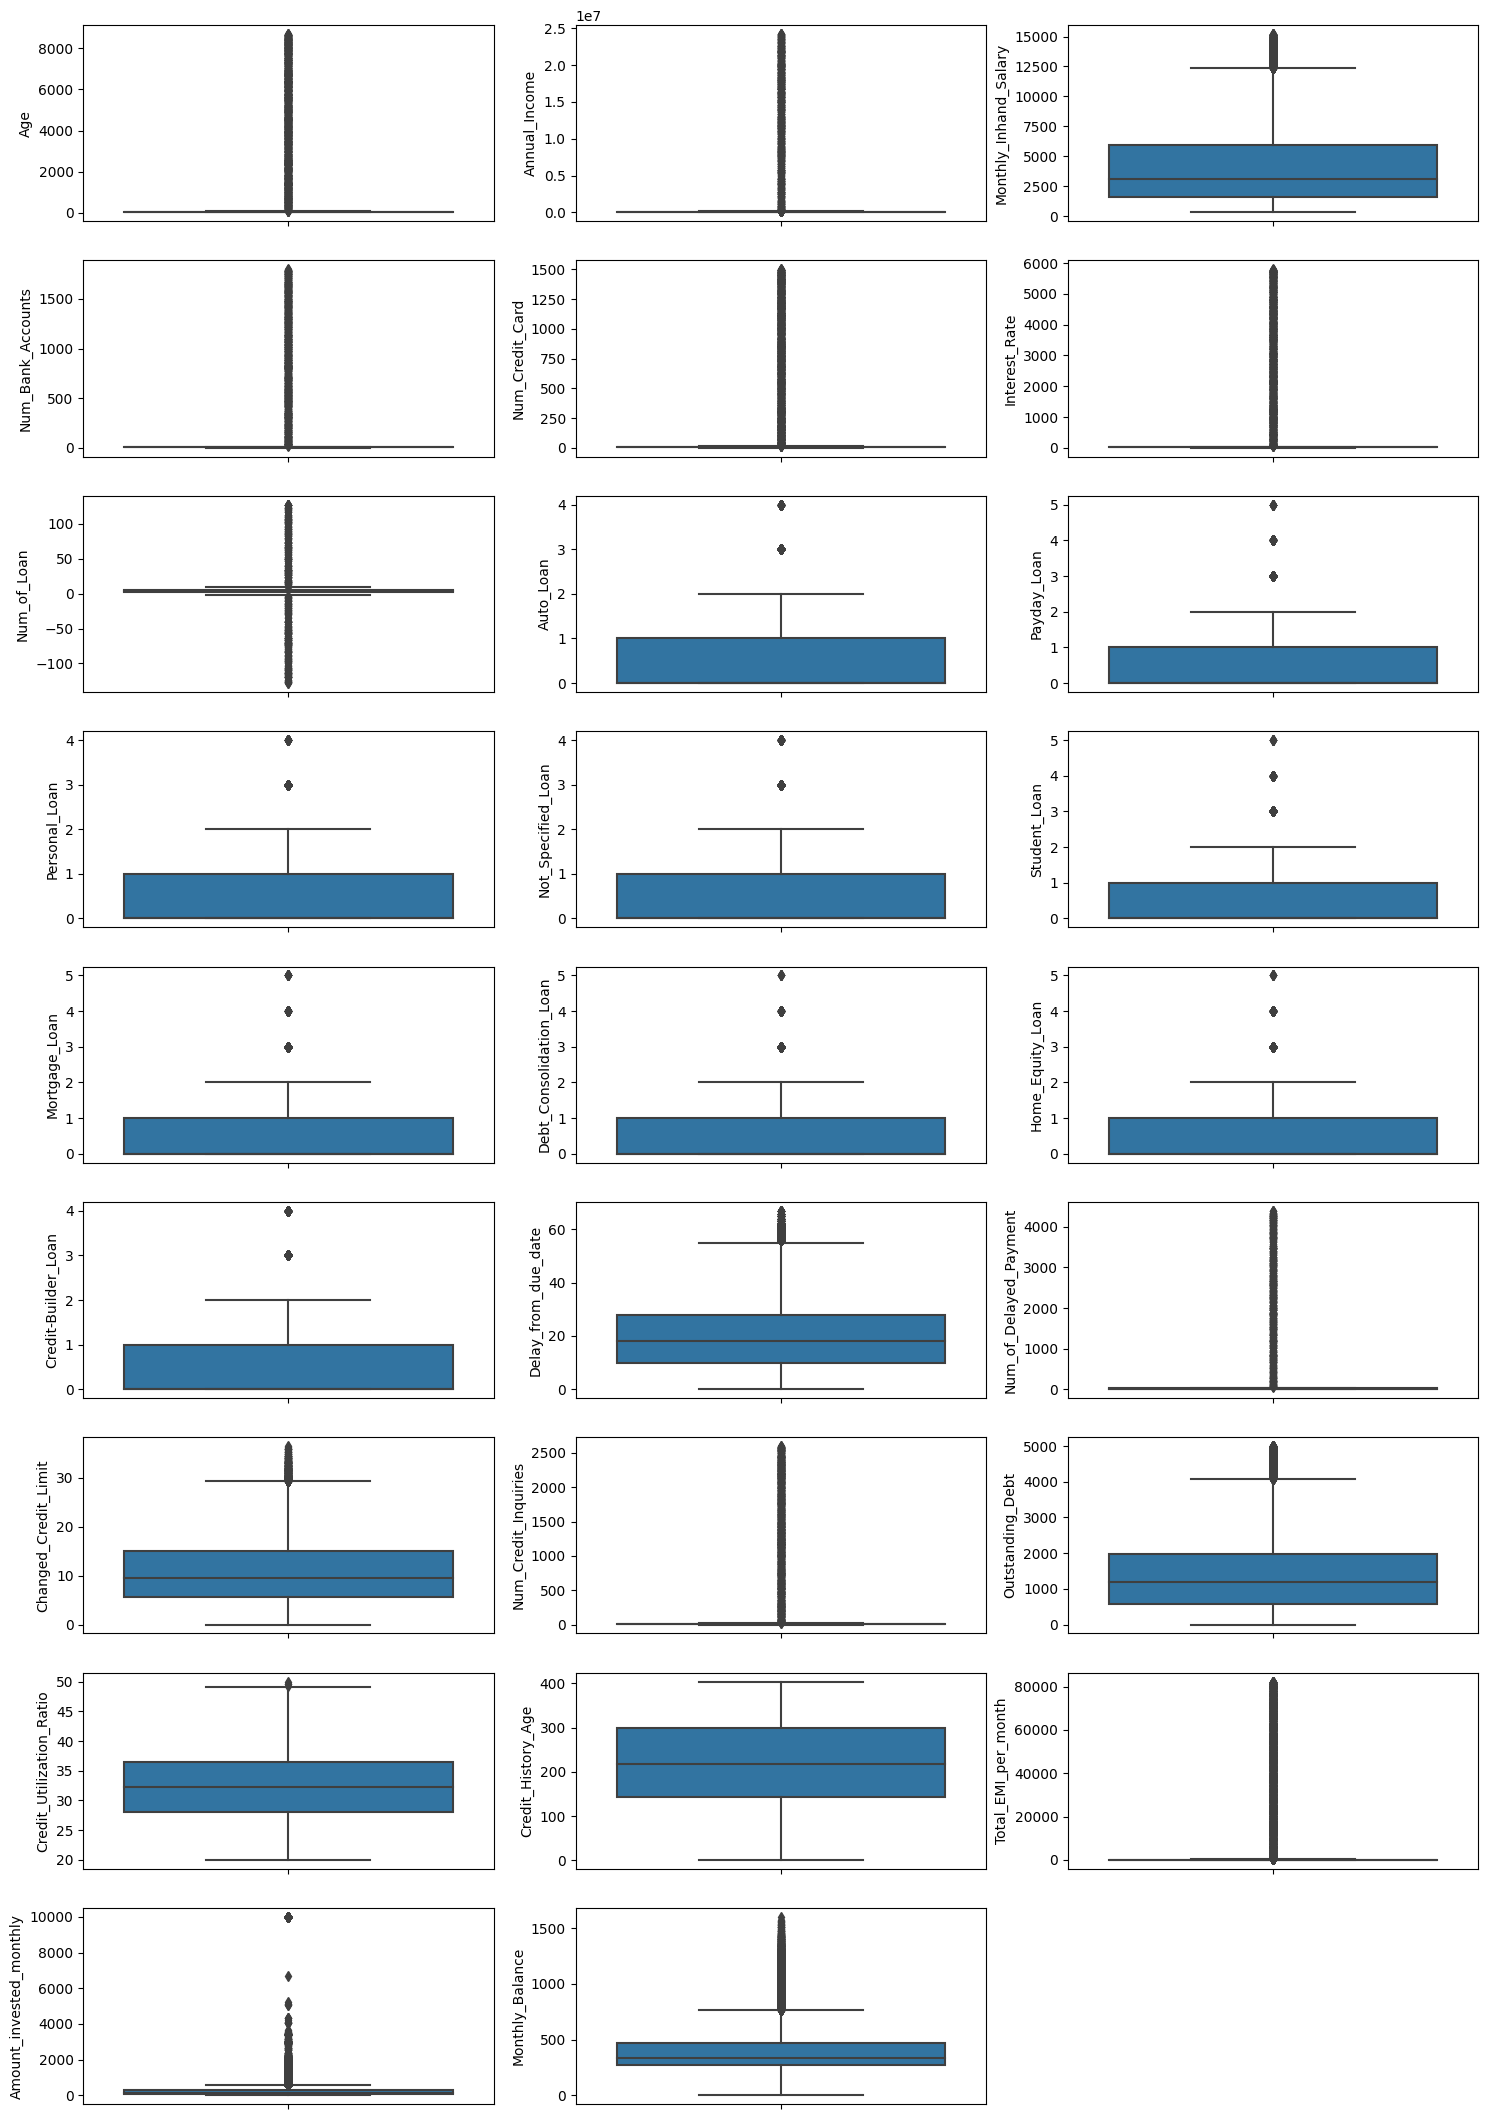

In [101]:
fig, axs = plt.subplots(nrows=9, ncols=3, figsize=(18, 27))

for idx, col in enumerate(num_columns):
    i, j = divmod(idx, 3)
    sns.boxplot(data=df_10, y=col, ax=axs[i, j])

axs.flatten()[-1].set_axis_off()

In [102]:
divmod(2,3)

(0, 2)

In [103]:
Q1 = df_10.Age.quantile(.25)
Q3 = df_10.Age.quantile(.75)
IQR = Q3 - Q1

Q1, Q3, IQR

(25.0, 42.0, 17.0)

In [104]:
Q1-1.5*IQR, Q3+1.5*IQR

(-0.5, 67.5)

In [105]:
def create_outliers_info(df, cols):
    cols_info = []
    
    for col in cols:
        q1 = df[col].quantile(.25)
        q3 = df[col].quantile(.75)
        iqr = q3 - q1
        outlier_lt = q1 - 1.5*iqr
        outlier_gt = q3 + 1.5*iqr
        cols_info.append([ outlier_lt, df[col].min(), outlier_gt, df[col].max() ])

    return pd.DataFrame(cols_info, index=cols, columns=[ 'Outliers_lower_bound', 'Min', 'Outliers_upper_bound', 'Max'])

In [106]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(create_outliers_info(df_10, num_columns))

,Outliers_lower_bound,Min,Outliers_upper_bound,Max
Age,-0.50,14.00,67.50,8698.00
Annual_Income,-59982.64,7005.93,151540.76,24198062.00
Monthly_Inhand_Salary,-4819.73,303.65,12355.75,15204.63
Num_Bank_Accounts,-2.00,0.00,14.00,1798.00
Num_Credit_Card,-0.50,0.00,11.50,1499.00
Interest_Rate,-10.00,1.00,38.00,5797.00
Num_of_Loan,-2.50,-128.00,9.50,127.00
Auto_Loan,-1.50,0.00,2.50,4.00
Payday_Loan,-1.50,0.00,2.50,5.00
Personal_Loan,-1.50,0.00,2.50,4.00


In [107]:
# cols_with_outliers = ['Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 
#                       'Num_of_Delayed_Payment', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 
#                       'Total_EMI_per_month']

In [108]:
with pd.option_context('display.max_columns', 33):
    display(
        df_10.assign(
        Num_of_Loan = lambda df_: df_[['Auto_Loan', 'Payday_Loan', 'Personal_Loan', 'Not_Specified_Loan', 
                                                'Student_Loan', 'Mortgage_Loan', 'Debt_Consolidation_Loan', 'Home_Equity_Loan', 
                                                'Credit-Builder_Loan']].sum(axis=1)
                )
    )

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Auto_Loan,Payday_Loan,Personal_Loan,Not_Specified_Loan,Student_Loan,Mortgage_Loan,Debt_Consolidation_Loan,Home_Equity_Loan,Credit-Builder_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,CUS_0xd40,January,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,3,7.0,11.27,4.0,Good,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,CUS_0xd40,April,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,5,4.0,6.27,4.0,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
2,CUS_0xd40,May,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,6,4.0,11.27,4.0,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
3,CUS_0xd40,June,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,8,4.0,9.27,4.0,Good,809.98,27.262259,270.0,No,49.574949,62.430172,High_spent_Medium_value_payments,340.479212,Good
4,CUS_0xd40,July,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,3,8.0,11.27,4.0,Good,809.98,22.537593,271.0,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90813,CUS_0x942c,April,25,Mechanic,39628.99,3359.415833,4,6,7,2,1,0,0,0,1,0,0,0,0,23,7.0,11.50,3.0,Good,502.38,34.663572,378.0,No,35.104023,60.971333,High_spent_Large_value_payments,479.866228,Poor
90814,CUS_0x942c,May,25,Mechanic,39628.99,3359.415833,4,6,7,2,1,0,0,0,1,0,0,0,0,18,7.0,11.50,3.0,Good,502.38,40.565631,379.0,No,35.104023,54.185950,High_spent_Medium_value_payments,496.651610,Poor
90815,CUS_0x942c,June,25,Mechanic,39628.99,3359.415833,4,6,5729,2,1,0,0,0,1,0,0,0,0,27,6.0,11.50,3.0,Good,502.38,41.255522,380.0,No,35.104023,24.028477,High_spent_Large_value_payments,516.809083,Poor
90816,CUS_0x942c,July,25,Mechanic,39628.99,3359.415833,4,6,7,2,1,0,0,0,1,0,0,0,0,20,6.0,11.50,3.0,Good,502.38,33.638208,381.0,No,35.104023,251.672582,Low_spent_Large_value_payments,319.164979,Standard


In [109]:
df_10.query('Num_of_Delayed_Payment > 32')

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
202,CUS_0x6048,May,43,Musician,18627.640,1387.303333,7,7,19,6,...,Bad,1793.54,25.585205,229.0,Yes,65.139488,24.346188,High_spent_Large_value_payments,289.244657,Poor
234,CUS_0x9b94,May,36,Manager,71681.400,5799.450000,3,6,15,1,...,Standard,1293.02,40.791137,311.0,Yes,53.923514,10000.000000,High_spent_Large_value_payments,358.095400,Good
249,CUS_0x42ac,January,36,Musician,15566.020,1423.168333,8,5,32,4,...,Standard,1693.95,37.409934,94.0,Yes,43.070520,65.986586,Low_spent_Small_value_payments,323.259728,Poor
347,CUS_0xb986,February,14,Developer,39887.220,3224.935000,9,9,16,5,...,Bad,3119.60,26.112222,150.0,Yes,133.470845,153.270725,High_spent_Medium_value_payments,295.751929,Poor
558,CUS_0x78e0,April,47,Accountant,17787.340,1242.278333,8,4,16,2,...,Standard,730.90,34.903092,360.0,No,20.063634,28.516044,High_spent_Medium_value_payments,325.648156,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90046,CUS_0xbb53,June,31,Lawyer,77633.040,6635.420000,7,5,34,5,...,Bad,3392.65,32.025465,9.0,Yes,227.777065,106.015126,High_spent_Large_value_payments,569.749810,Poor
90288,CUS_0x7b65,March,27,Mechanic,8968.555,880.379583,10,8,30,8,...,Bad,2502.86,38.044111,137.0,Yes,57.078833,93.647887,Low_spent_Small_value_payments,227.311238,Poor
90418,CUS_0x650,March,28,Lawyer,21471.580,1879.298333,7,3,16,2,...,Standard,68.06,40.940335,285.0,No,23.498319,33.192490,High_spent_Small_value_payments,391.239024,Standard
90419,CUS_0x650,April,28,Lawyer,21471.580,1879.298333,7,3,16,2,...,Standard,68.06,31.039063,286.0,No,23.498319,12.340388,High_spent_Medium_value_payments,392.091127,Standard


In [110]:
df_10.query('Num_of_Delayed_Payment > 32').groupby(['Customer_ID', 'Num_of_Delayed_Payment'])['Customer_ID'].count()

Customer_ID  Num_of_Delayed_Payment
CUS_0x1009   1749.0                    1
CUS_0x109f   2230.0                    1
CUS_0x1100   1636.0                    1
CUS_0x1182   921.0                     1
CUS_0x1190   1766.0                    1
                                      ..
CUS_0xec4    1498.0                    1
CUS_0xf42    328.0                     1
CUS_0xf50    1536.0                    1
CUS_0xf6c    2204.0                    1
CUS_0xf9f    1087.0                    1
Name: Customer_ID, Length: 674, dtype: int64

In [111]:
df_10.query('Num_Credit_Card > 11')

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
31,CUS_0x95ee,January,31,Lawyer,73928.46,5988.705000,4,1288,8,0,...,Good,548.20,39.962685,383.0,No,15015.000000,98.674410,High_spent_Large_value_payments,740.196090,Good
129,CUS_0x4100,June,32,Entrepreneur,19300.34,1512.361667,6,1029,17,5,...,Bad,2430.21,25.847791,223.0,Yes,49.572062,83.447449,Low_spent_Large_value_payments,288.216656,Poor
135,CUS_0x132f,April,41,Musician,19514.88,1828.240000,7,488,17,0,...,Standard,881.40,34.503707,234.0,No,0.000000,45.388820,High_spent_Medium_value_payments,387.435180,Poor
168,CUS_0x4d43,August,48,Entrepreneur,20787.69,1999.307500,8,1381,14,3,...,Standard,614.60,35.344188,221.0,No,42.221993,21.745531,High_spent_Large_value_payments,375.963226,Standard
230,CUS_0x9b94,January,36,Manager,71681.40,5799.450000,3,518,15,1,...,Standard,1293.02,40.339024,307.0,Yes,53.923514,301.292082,Low_spent_Small_value_payments,514.729404,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90460,CUS_0x5d6d,June,38,Writer,126514.72,10341.893333,8,1255,5,3,...,Standard,470.42,29.696182,355.0,No,61447.000000,902.340388,Low_spent_Small_value_payments,109.816092,Good
90469,CUS_0x2829,August,32,Journalist,64901.37,5298.447500,3,232,20,0,...,Standard,442.06,29.145534,377.0,Yes,0.000000,126.263036,High_spent_Large_value_payments,643.581714,Standard
90473,CUS_0xae66,April,30,Writer,142560.36,11773.030000,6,1430,13,1,...,Standard,220.75,34.671699,210.0,No,76.772094,982.946968,Low_spent_Large_value_payments,387.583938,Standard
90613,CUS_0xc345,February,23,Architect,60015.32,5121.276667,7,679,14,-46,...,Standard,1095.15,35.864367,183.0,Yes,187.008683,241.313632,Low_spent_Large_value_payments,353.805352,Standard


In [112]:
df_10.query('Num_Credit_Card > 11').groupby(['Customer_ID', 'Num_Credit_Card'])['Customer_ID'].count()

Customer_ID  Num_Credit_Card
CUS_0x104a   690                1
CUS_0x104f   1405               1
CUS_0x105b   1278               1
CUS_0x106f   106                1
CUS_0x1075   1349               1
                               ..
CUS_0xfb6    774                1
CUS_0xfcb    1477               1
CUS_0xfd1    1440               1
CUS_0xff3    363                1
             1168               1
Name: Customer_ID, Length: 2068, dtype: int64

In [113]:
df_10.query('Total_EMI_per_month > 357')

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
31,CUS_0x95ee,January,31,Lawyer,73928.46,5988.705000,4,1288,8,0,...,Good,548.20,39.962685,383.0,No,15015.000000,98.674410,High_spent_Large_value_payments,740.196090,Good
36,CUS_0x95ee,June,31,Lawyer,73928.46,5988.705000,4,5,8,0,...,Good,548.20,35.275437,388.0,No,15515.000000,235.790325,Low_spent_Large_value_payments,633.080175,Good
40,CUS_0x284a,March,34,Lawyer,131313.40,10469.207759,0,1,8,2,...,Good,352.16,31.803134,369.0,No,911.220179,188.064321,High_spent_Large_value_payments,1038.569407,Good
41,CUS_0x284a,April,34,Lawyer,131313.40,10469.207759,0,1,8,2,...,Good,352.16,42.645785,370.0,No,23834.000000,337.434956,High_spent_Medium_value_payments,899.198772,Good
42,CUS_0x284a,May,34,Lawyer,131313.40,10469.207759,0,1,8,2,...,Good,352.16,40.902517,371.0,No,32662.000000,263.378909,High_spent_Large_value_payments,963.254819,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90782,CUS_0x2084,August,21,Architect,38321.39,3106.647859,4,4,3,4,...,Good,678.57,28.951691,210.0,No,362.072453,259.135635,Low_spent_Medium_value_payments,242.038135,Standard
90783,CUS_0x372c,January,18,Lawyer,42903.79,3468.315833,0,4,6,1,...,Good,1079.48,27.289440,337.0,No,50894.000000,78.514945,High_spent_Small_value_payments,493.341182,Good
90789,CUS_0xf16,March,45,Media_Manager,16680.35,1528.029167,1,1,5,4,...,Good,897.16,30.472041,255.0,No,75011.000000,75.504972,Low_spent_Medium_value_payments,316.184384,Good
90804,CUS_0x8600,February,28,Architect,20002.88,1929.906667,10,8,29,5,...,Bad,3571.70,39.772607,69.0,Yes,12112.000000,148.275233,Low_spent_Small_value_payments,273.750662,Poor


In [114]:
df_10.query('Total_EMI_per_month > 357').groupby(['Customer_ID', 'Total_EMI_per_month'])['Customer_ID'].count()

Customer_ID  Total_EMI_per_month
CUS_0x1013   48538.000000           1
CUS_0x103e   27369.000000           1
CUS_0x105b   79286.000000           1
CUS_0x1069   10251.000000           1
CUS_0x106f   1357.000000            1
                                   ..
CUS_0xf5d    447.834152             8
CUS_0xf70    27749.000000           1
CUS_0xf8d    45104.000000           1
CUS_0xfdf    78333.000000           1
CUS_0xfe4    540.072238             8
Name: Customer_ID, Length: 3521, dtype: int64

In [115]:
df_10.assign(
    Annual_Income = lambda df_: np.where(df_['Annual_Income'] > 152_000, 152_000, df_['Annual_Income'])
)['Annual_Income'].describe()

count     90818.000000
mean      50883.841237
std       38392.024630
min        7005.930000
25%       19338.630000
50%       37346.160000
75%       72219.480000
max      152000.000000
Name: Annual_Income, dtype: float64

In [116]:
df_10.Interest_Rate.value_counts()

Interest_Rate
8       4469
5       4456
6       4230
10      4061
9       4052
        ... 
3617       1
2147       1
4995       1
1899       1
5729       1
Name: count, Length: 1618, dtype: int64

In [117]:
df_10.Num_of_Delayed_Payment.value_counts()

Num_of_Delayed_Payment
19.0      5388
17.0      5358
16.0      5327
10.0      5289
15.0      5228
          ... 
1164.0       1
2616.0       1
848.0        1
4134.0       1
2047.0       1
Name: count, Length: 652, dtype: int64

In [118]:
def cap_outliers(df:pd.DataFrame, col:str, rounded=False):
    q1 = df[col].quantile(.25)
    q3 = df[col].quantile(.75)
    iqr = q3 - q1
    lower_bound, upper_bound = q1-1.5*iqr, q3+1.5*iqr

    if rounded:
        return np.where(
            df[col]>upper_bound, int(upper_bound),
            np.where(
                df[col]<lower_bound, int(lower_bound),
                df[col]
            )
        )

    return np.where(
        df[col]>upper_bound, upper_bound,
        np.where(
            df[col]<lower_bound, lower_bound,
            df[col]
        )
    )

In [119]:
cols_with_outliers = ['Age', 'Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 
                      'Num_of_Loan', 'Num_of_Delayed_Payment', 'Num_of_Delayed_Payment', 'Num_Credit_Inquiries', 
                      'Total_EMI_per_month']

In [120]:
start = datetime.now()

df11 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .assign(**{c: lambda df_, c=c: strip_series(df_[c]) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c], errors='coerce') for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: cap_outliers(df_, c, rounded=True) for c in cols_with_outliers})
    .pipe(lambda _df: reduce(drop_rows_lt_zero2, cols_to_positive, _df))
    .assign(
        Occupation = lambda _df: _df.groupby(['Customer_ID'])['Occupation'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Occupation == "_______"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .assign(
        Credit_Mix = lambda _df: _df.groupby(['Customer_ID'])['Credit_Mix'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Credit_Mix == "_"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .assign( 
        Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace({'!@9#%8': np.nan}),
        Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace({'NM': np.nan})
    )
    .pipe(lambda _df: unravel_type_of_loan_into_separate_columns(_df))
    .pipe(lambda df_: df_.rename(columns=lambda col: col.replace(' ', '_')))
    .pipe(lambda df_: df_.rename(columns={'Not_Specified': 'Not_Specified_Loan'}))
    .pipe(lambda df_: df_.drop(['ID', 'Name', 'SSN', 'Type_of_Loan', 'Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].astype(np.int8) for c in cols_to_int8})
    .assign(**{c: lambda df_, c=c: df_[c].astype(np.int16) for c in cols_to_int16})
    .assign(
        **{c: lambda _df, c=c: _df.groupby(['Customer_ID'])[f'{c}'].transform(
            lambda x: x.fillna(x.mode().iat[0]) ) \
           for c in fillna_with_mode_per_customer}
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.ffill()+1) )
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.bfill()-1) )
    )
    .assign(
        Amount_invested_monthly = lambda _df: _df.groupby(['Customer_ID'])['Amount_invested_monthly'].transform(
            lambda x: x.fillna(x.mean()) )
    )
    .assign(
        Monthly_Balance = lambda _df: _df.groupby(['Customer_ID'])['Monthly_Balance'].transform(
            lambda x: x.fillna(x.mean()) )
    )
)

end = datetime.now()
print( f"Function RunTime ≈ {(end-start).total_seconds():.0f} seconds" )

Function RunTime ≈ 41 seconds


In [121]:
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(create_outliers_info(df11, num_columns))

,Outliers_lower_bound,Min,Outliers_upper_bound,Max
Age,-0.50,14.00,67.50,69.00
Annual_Income,-59982.64,7005.93,151540.76,152791.00
Monthly_Inhand_Salary,-4819.73,303.65,12355.75,15204.63
Num_Bank_Accounts,-2.00,0.00,14.00,13.00
Num_Credit_Card,-0.50,0.00,11.50,11.00
Interest_Rate,-10.00,1.00,38.00,38.00
Num_of_Loan,-2.50,0.00,9.50,11.00
Auto_Loan,-1.50,0.00,2.50,4.00
Payday_Loan,-1.50,0.00,2.50,5.00
Personal_Loan,-1.50,0.00,2.50,4.00


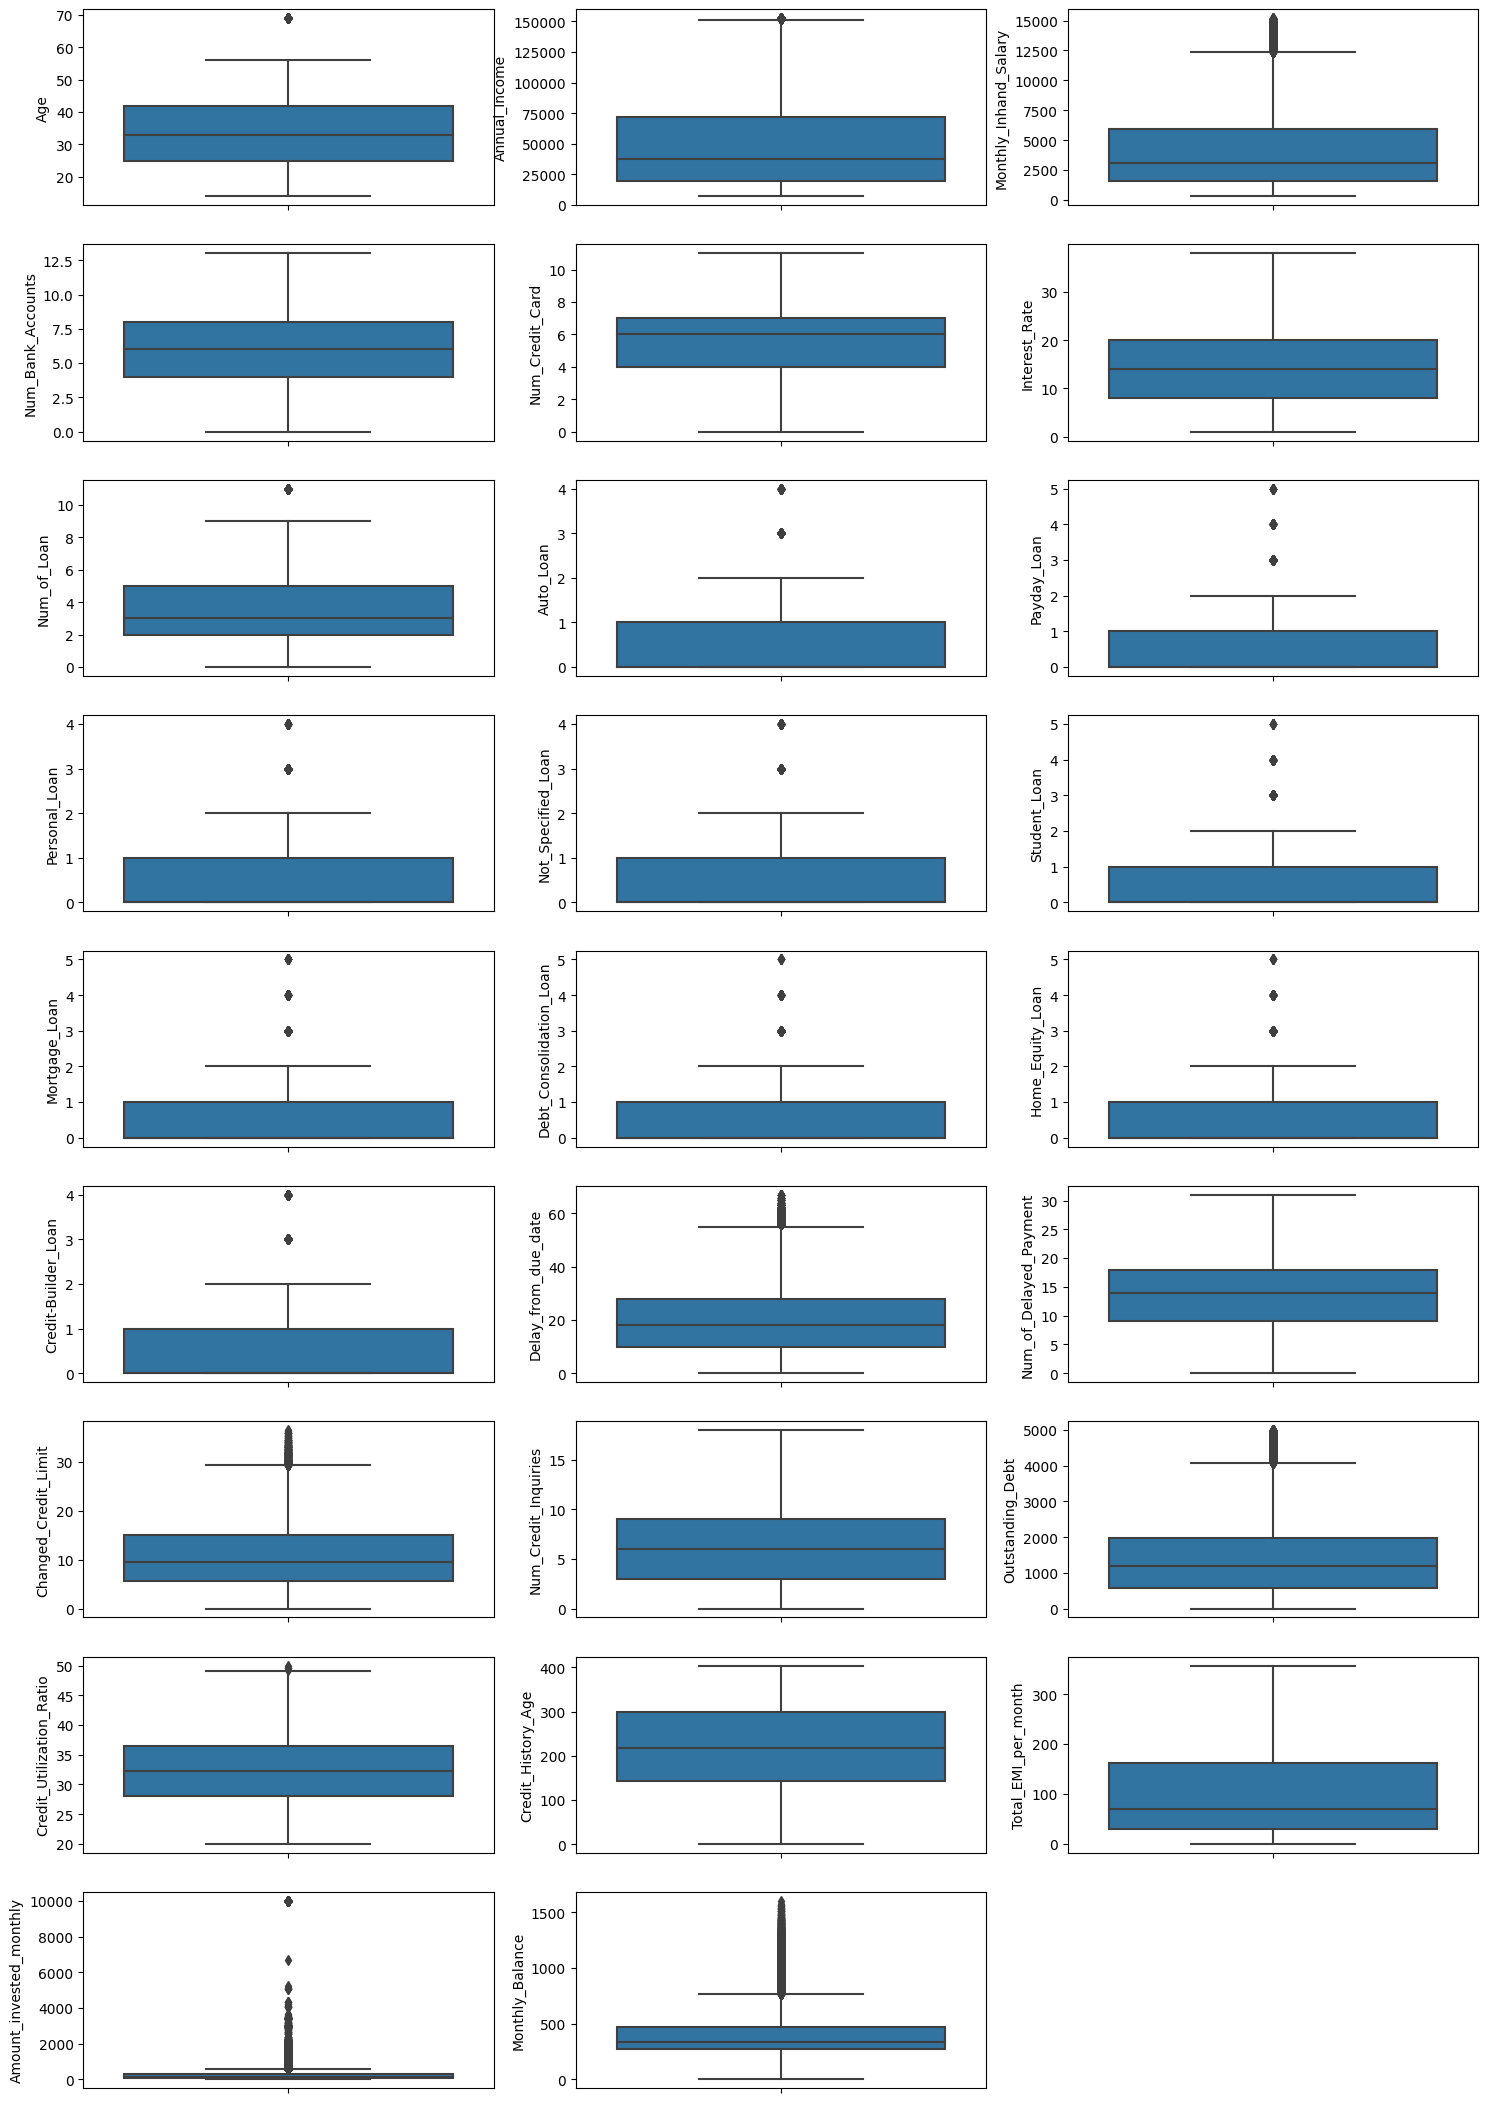

In [122]:
fig, axs = plt.subplots(nrows=9, ncols=3, figsize=(18, 27))

for idx, col in enumerate(num_columns):
    i, j = divmod(idx, 3)
    sns.boxplot(data=df11, y=col, ax=axs[i, j])

axs.flatten()[-1].set_axis_off()

In [123]:
df11.shape

(90818, 33)

In [124]:
df11.query('Amount_invested_monthly > 567')[['Customer_ID', 'Monthly_Inhand_Salary', 'Amount_invested_monthly']]

,Customer_ID,Monthly_Inhand_Salary,Amount_invested_monthly
15,CUS_0x2dbc,12187.220000,10000.000000
16,CUS_0x2dbc,12187.220000,825.216270
20,CUS_0x2dbc,12187.220000,10000.000000
34,CUS_0x95ee,5988.705000,618.202391
43,CUS_0x284a,10469.207759,930.391898
...,...,...,...
90752,CUS_0x2654,11777.746667,1104.416249
90768,CUS_0x51b3,4908.863333,606.436542
90775,CUS_0x51b3,4908.863333,10000.000000
90792,CUS_0xf16,1528.029167,10000.000000


In [125]:
AIM_above_avg = df11.query('Amount_invested_monthly > 567')[['Customer_ID', 'Monthly_Inhand_Salary', 'Amount_invested_monthly']]

AIM_above_avg.query('Amount_invested_monthly > Monthly_Inhand_Salary')

,Customer_ID,Monthly_Inhand_Salary,Amount_invested_monthly
94,CUS_0x33d2,2942.148333,10000.000000
114,CUS_0xfdb,2898.385000,10000.000000
133,CUS_0x132f,1828.240000,10000.000000
162,CUS_0x4d43,1999.307500,10000.000000
234,CUS_0x9b94,5799.450000,10000.000000
...,...,...,...
90710,CUS_0x47fa,5440.945000,10000.000000
90744,CUS_0x1619,1523.665000,10000.000000
90775,CUS_0x51b3,4908.863333,10000.000000
90792,CUS_0xf16,1528.029167,10000.000000


In [126]:
AIM_above_avg.groupby(['Customer_ID', 'Amount_invested_monthly'])['Amount_invested_monthly'].count()

Customer_ID  Amount_invested_monthly
CUS_0x100b   617.079267                 1
             661.624048                 1
             758.083195                 1
             1861.759880                1
             10000.000000               1
                                       ..
CUS_0xfe4    10000.000000               1
CUS_0xff6    978.785786                 1
             1186.582604                1
             10000.000000               1
CUS_0xffc    10000.000000               1
Name: Amount_invested_monthly, Length: 9247, dtype: int64

In [127]:
# transformed_Amount_invested_monthly = df11.assign(
#     Amount_invested_monthly = lambda df_ : np.where(
#         df_['Amount_invested_monthly'] > df_['Monthly_Inhand_Salary'],
#         df_['Monthly_Inhand_Salary'],
#         df_['Amount_invested_monthly']
#     )
# )[['Amount_invested_monthly']].reset_index(drop=True)


# Amount_invested_monthly = (
#     pd.concat([df11.Monthly_Inhand_Salary, df11.Amount_invested_monthly, transformed_Amount_invested_monthly], axis=1)
# )

# Amount_invested_monthly.columns = ['Monthly_Inhand_Salary', 'Amount_invested_monthly_Original', 'Amount_invested_monthly_Transformed']

# Amount_invested_monthly.query('Amount_invested_monthly_Original > 567')

In [128]:
df11.query('Amount_invested_monthly > Monthly_Inhand_Salary')[['Monthly_Inhand_Salary', 'Amount_invested_monthly']]

,Monthly_Inhand_Salary,Amount_invested_monthly
94,2942.148333,10000.000000
114,2898.385000,10000.000000
133,1828.240000,10000.000000
162,1999.307500,10000.000000
234,5799.450000,10000.000000
...,...,...
90710,5440.945000,10000.000000
90744,1523.665000,10000.000000
90775,4908.863333,10000.000000
90792,1528.029167,10000.000000


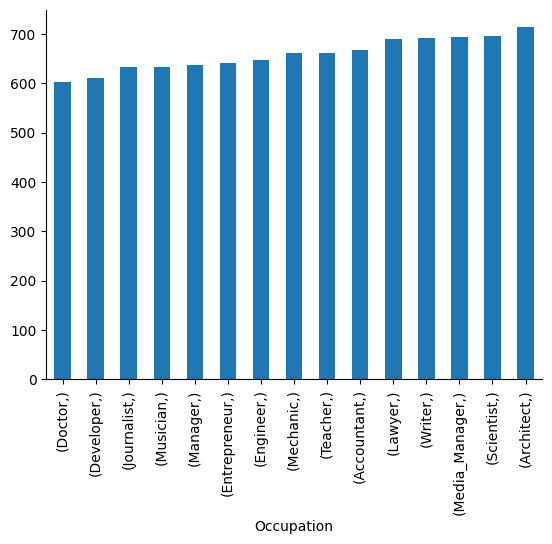

In [129]:
ax = df11.query('Amount_invested_monthly > 567')[['Occupation']].value_counts().sort_values().plot(kind='bar')
ax.spines[['top', 'right']].set_visible(False)

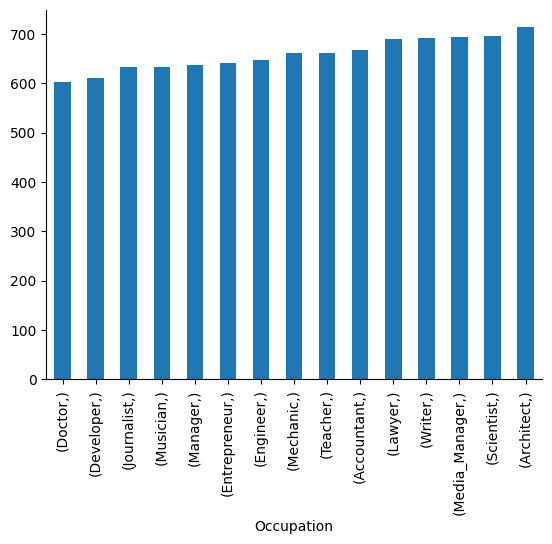

In [130]:
ax = (df11.query('Amount_invested_monthly > 567')[['Occupation']]
    .value_counts()
    .sort_values()
    ).plot(kind='bar')

ax.spines[['top', 'right']].set_visible(False)

In [131]:
df11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90818 entries, 0 to 90817
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               90818 non-null  object 
 1   Month                     90818 non-null  object 
 2   Age                       90818 non-null  int16  
 3   Occupation                90818 non-null  object 
 4   Annual_Income             90818 non-null  float64
 5   Monthly_Inhand_Salary     90818 non-null  float64
 6   Num_Bank_Accounts         90818 non-null  int16  
 7   Num_Credit_Card           90818 non-null  int16  
 8   Interest_Rate             90818 non-null  int16  
 9   Num_of_Loan               90818 non-null  int16  
 10  Delay_from_due_date       90818 non-null  int8   
 11  Num_of_Delayed_Payment    90818 non-null  float64
 12  Changed_Credit_Limit      90818 non-null  float64
 13  Num_Credit_Inquiries      90818 non-null  float64
 14  Credit

In [132]:
df11.to_csv('cleaned_data.csv', index=False)

In [133]:
(
    df11.groupby(['Month', 'Credit_Score'])[['Credit_Score']].count()
    .rename(columns={'Credit_Score': 'Count'})
    .reset_index(level=[1])
    # .plot('Credit_Score', 'Count', kind='bar', stacked=True)
)

,Credit_Score,Count
Month,,
April,Good,2054
April,Poor,3361
April,Standard,5924
August,Good,2124
August,Poor,3289
August,Standard,5901
February,Good,1730
February,Poor,3247
February,Standard,6347


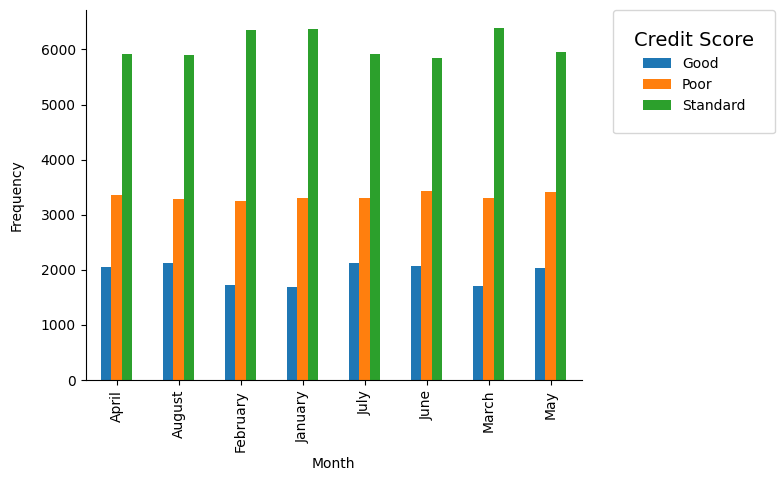

In [134]:
ax = (
    df11.groupby(['Month', 'Credit_Score'])[['Credit_Score']].count()
    .unstack()
    .plot(kind='bar')
)

ax.set_ylabel('Frequency', labelpad=12)

ax.legend(['Good', 'Poor', 'Standard'], 
          bbox_to_anchor=(1.05, 1.02), 
          loc='upper left',
          title="Credit Score",
          title_fontsize=14,
          borderpad=1.5)

ax.spines[['top', 'right']].set_visible(False)

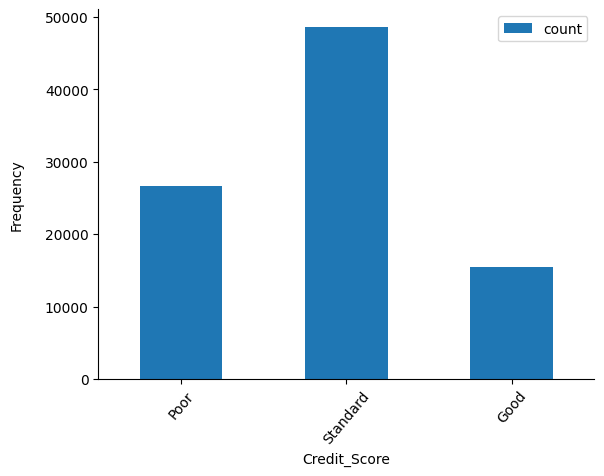

In [135]:
ax = (
    pd.DataFrame(
    df11.Credit_Score
    .value_counts()
    )
    .reindex(['Poor', 'Standard', 'Good'])
    .plot(kind='bar')
)

ax.spines[['top', 'right']].set_visible(False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_ylabel('Frequency', labelpad=15)

plt.show()

In [136]:
df11.Monthly_Balance.value_counts()

Monthly_Balance
257.298961    5
161.193017    4
175.190053    4
712.737936    4
166.643049    4
             ..
235.539689    1
337.725739    1
203.673713    1
346.434945    1
393.673696    1
Name: count, Length: 90611, dtype: int64

In [137]:
def groom_list_of_loans(lst):
    if isinstance(lst, list):
        return [item.strip().replace(' ', '_') for item in lst]
    else:
        return lst


def check_exsitance(lst, item):
    if isinstance(lst, list):
        if (item in lst):
            return 1
        else:
            return 0
    else:
        return 0

In [138]:
# def unravel_type_of_loan_into_separate_columns2(df_):
#     loans_types = ['Auto_Loan',
#                  'Credit-Builder_Loan',
#                  'Debt_Consolidation_Loan',
#                  'Home_Equity_Loan',
#                  'Mortgage_Loan',
#                  'Not_Specified',
#                  'Payday_Loan',
#                  'Personal_Loan',
#                  'Student_Loan']
#     lists_of_loans = df_['Type_of_Loan'].str.replace(' and ', '').str.split(',').apply(lambda x: groom_list_of_loans(x))
#     for loan_type in loans_types:
#         df_[loan_type] = lists_of_loans.apply(lambda x: check_exsitance(x, loan_type) )
#     return df_

In [139]:
# unravel_type_of_loan_into_separate_columns2(df)

In [140]:
start = datetime.now()

df12 = (
    df.Credit_History_Age.str.extract(r'(\d+) Years and (\d+) Months')
    .rename(columns={0:'Credit_History_Years', 1:'Credit_History_Months'})
    .pipe(lambda df_: pd.concat([df, df_], axis=1))
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c]) for c in ['Credit_History_Years', 'Credit_History_Months']})
    .assign( Credit_History_Age = lambda df_: df_.Credit_History_Years*12 + df_.Credit_History_Months)
    .assign(**{c: lambda df_, c=c: strip_series(df_[c]) for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: pd.to_numeric(df_[c], errors='coerce') for c in cols_to_num})
    .assign(**{c: lambda df_, c=c: cap_outliers(df_, c, rounded=True) for c in cols_with_outliers})
    .pipe(lambda _df: reduce(drop_rows_lt_zero2, cols_to_positive, _df))
    .assign(
        Occupation = lambda _df: _df.groupby(['Customer_ID'])['Occupation'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Occupation == "_______"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .assign(
        Credit_Mix = lambda _df: _df.groupby(['Customer_ID'])['Credit_Mix'].transform(
            lambda x: x.mode().iat[0] )
    )
    .pipe(lambda _df: _df.drop( _df.query('Credit_Mix == "_"').index ) )
    .pipe(lambda _df: _df.reset_index(drop=True))
    .assign( 
        Payment_Behaviour = lambda df_: df_.Payment_Behaviour.replace({'!@9#%8': np.nan}),
        Payment_of_Min_Amount = lambda df_: df_.Payment_of_Min_Amount.replace({'NM': np.nan})
    )
    .pipe(lambda _df: unravel_type_of_loan_into_separate_columns(_df))
    .pipe(lambda df_: df_.rename(columns=lambda col: col.replace(' ', '_')))
    .pipe(lambda df_: df_.rename(columns={'Not_Specified': 'Not_Specified_Loan'}))
    .pipe(lambda df_: df_.drop(['ID', 'Name', 'SSN', 'Type_of_Loan', 'Credit_History_Years', 'Credit_History_Months'], axis=1))
    .assign(**{c: lambda df_, c=c: df_[c].astype(np.int8) for c in cols_to_int8})
    .assign(**{c: lambda df_, c=c: df_[c].astype(np.int16) for c in cols_to_int16})
    .assign(
        **{c: lambda _df, c=c: _df.groupby(['Customer_ID'])[f'{c}'].transform(
            lambda x: x.fillna(x.mode().iat[0]) ) \
           for c in fillna_with_mode_per_customer}
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.ffill()+1) )
    )
    .assign(
        Credit_History_Age = lambda _df: _df.groupby(['Customer_ID'])['Credit_History_Age'].transform(
            lambda x: x.fillna(x.bfill()-1) )
    )
    .assign(
        Amount_invested_monthly = lambda _df: _df.groupby(['Customer_ID'])['Amount_invested_monthly'].transform(
            lambda x: x.fillna(x.mean()) )
    )
    .assign(
        Monthly_Balance = lambda _df: _df.groupby(['Customer_ID'])['Monthly_Balance'].transform(
            lambda x: x.fillna(x.mean()) ),
        Amount_invested_monthly = lambda df_ : np.where(
        df_['Amount_invested_monthly'] > df_['Monthly_Inhand_Salary'],
        np.nan,
        df_['Amount_invested_monthly'] )
    )
    .assign(
        Amount_invested_monthly = lambda _df: _df.groupby(['Customer_ID'])['Amount_invested_monthly'].transform(
            lambda x: x.fillna(x.mean()) )
    )
)

end = datetime.now()
print( f"Function RunTime ≈ {(end-start).total_seconds():.0f} seconds" )

Function RunTime ≈ 44 seconds


In [141]:
df12.shape

(90818, 33)

In [142]:
df12.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90818 entries, 0 to 90817
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               90818 non-null  object 
 1   Month                     90818 non-null  object 
 2   Age                       90818 non-null  int16  
 3   Occupation                90818 non-null  object 
 4   Annual_Income             90818 non-null  float64
 5   Monthly_Inhand_Salary     90818 non-null  float64
 6   Num_Bank_Accounts         90818 non-null  int16  
 7   Num_Credit_Card           90818 non-null  int16  
 8   Interest_Rate             90818 non-null  int16  
 9   Num_of_Loan               90818 non-null  int16  
 10  Delay_from_due_date       90818 non-null  int8   
 11  Num_of_Delayed_Payment    90818 non-null  float64
 12  Changed_Credit_Limit      90818 non-null  float64
 13  Num_Credit_Inquiries      90818 non-null  float64
 14  Credit

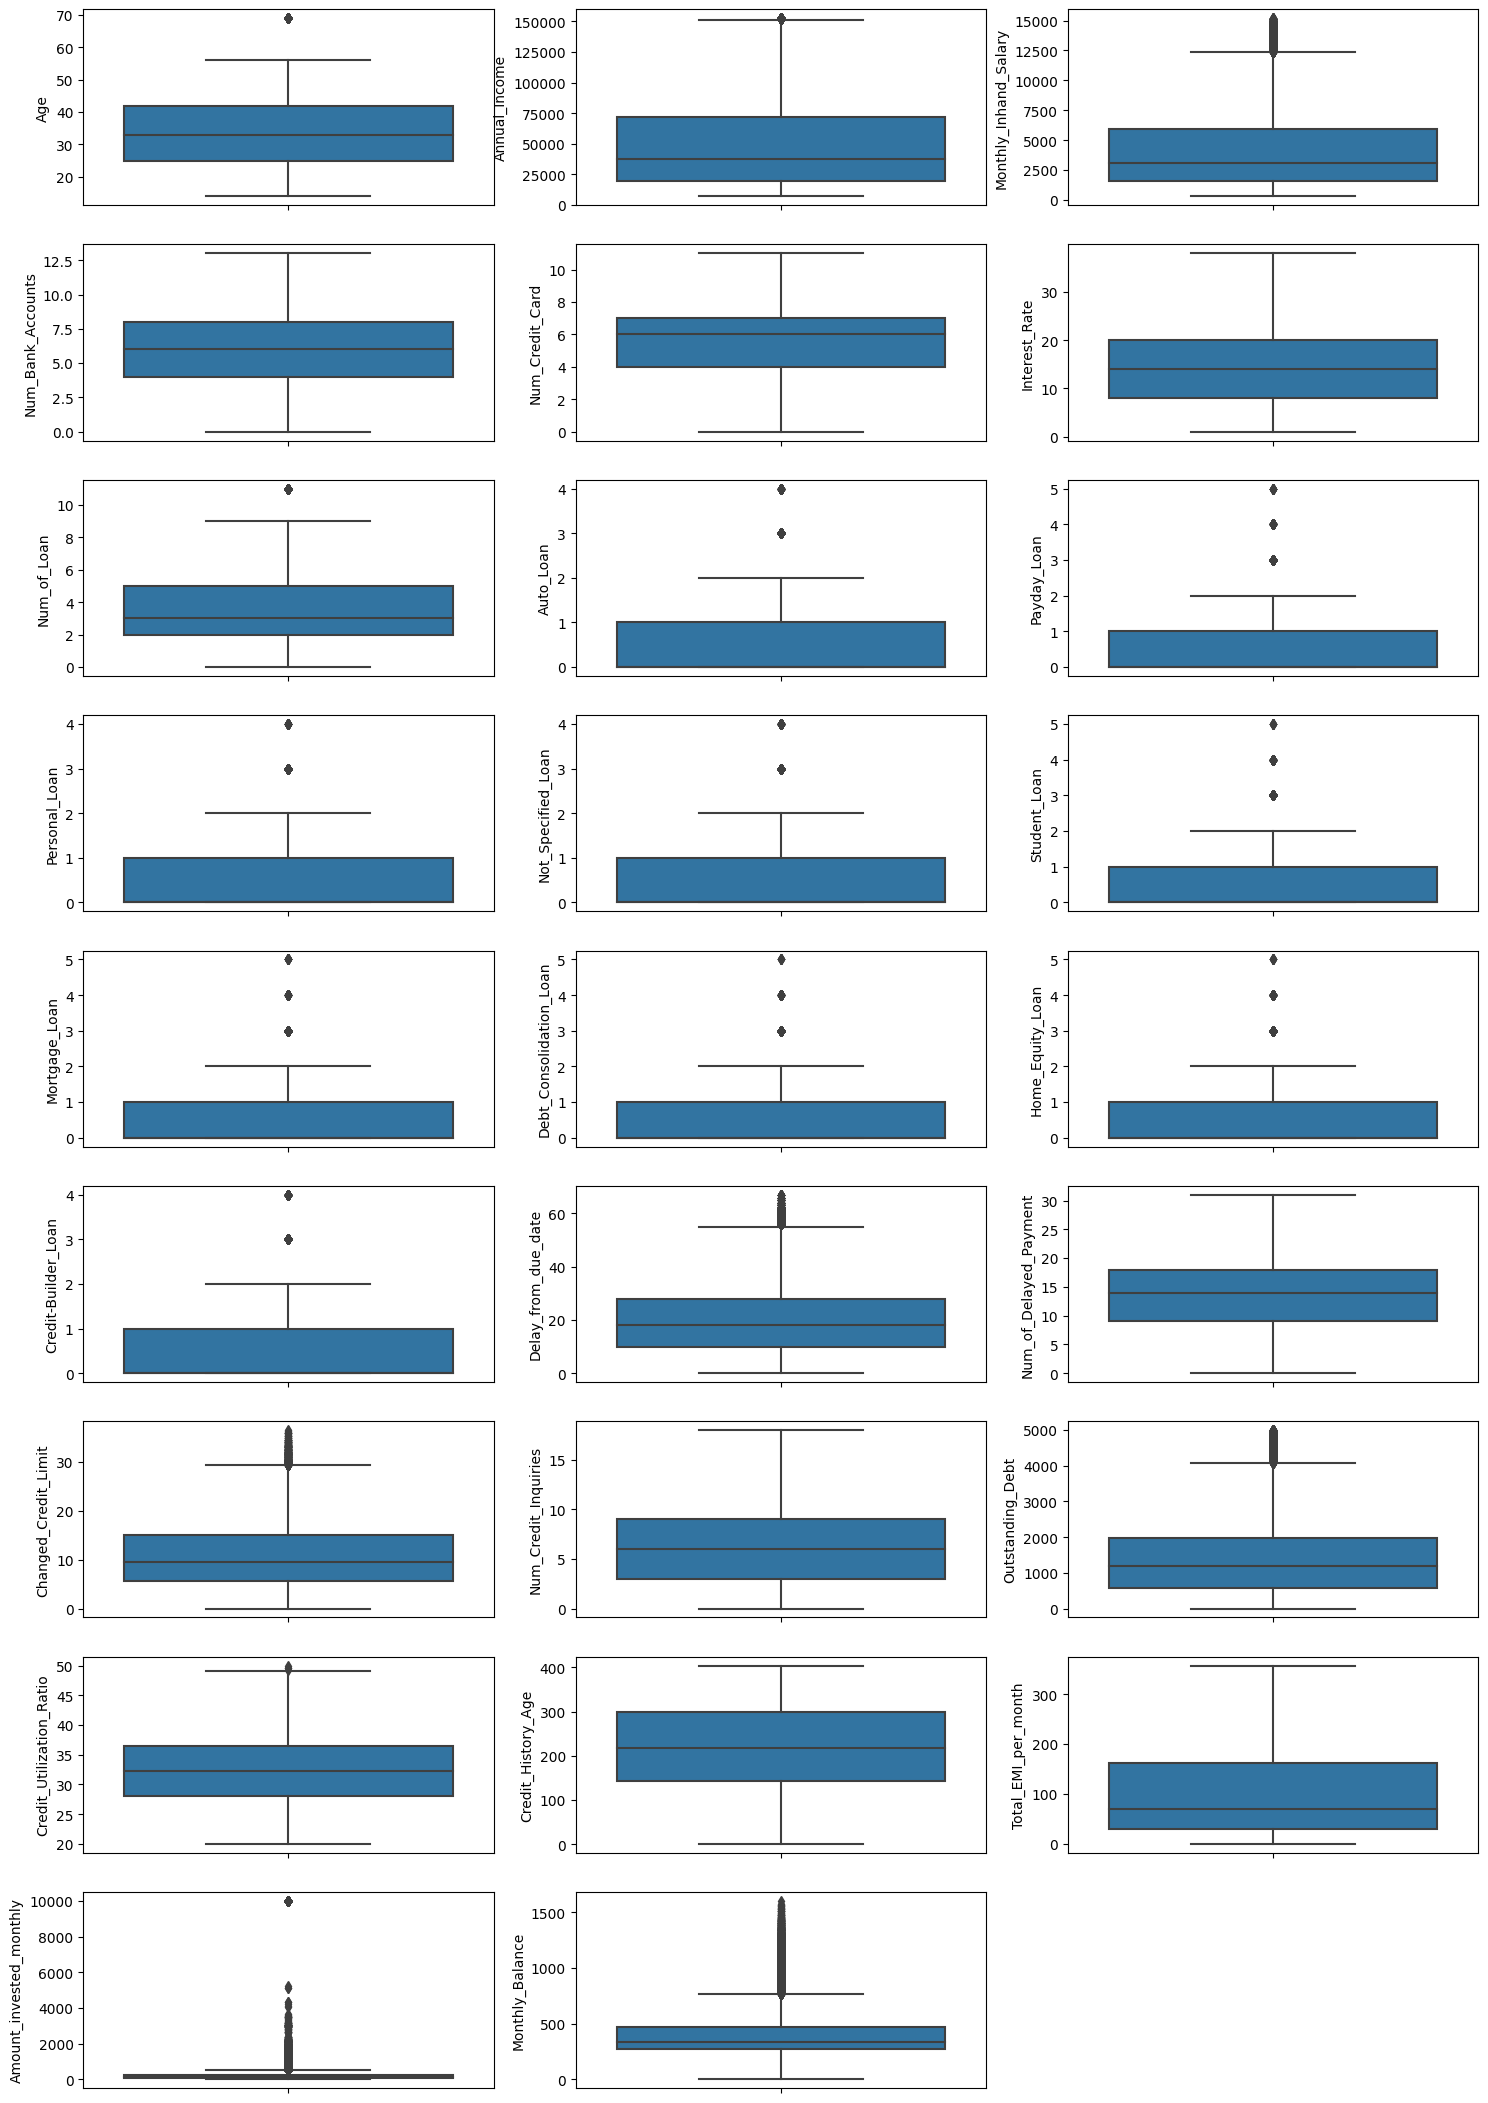

In [143]:
fig, axs = plt.subplots(nrows=9, ncols=3, figsize=(18, 27))

for idx, col in enumerate(num_columns):
    i, j = divmod(idx, 3)
    sns.boxplot(data=df12, y=col, ax=axs[i, j])

axs.flatten()[-1].set_axis_off()

In [144]:
df12 = df12.reindex(columns=ordered_columns)

In [145]:
df12.to_csv("cleaned_data.csv", index=False)

In [146]:
df12.shape

(90818, 33)

In [147]:
with pd.option_context('display.max_columns', 33):
    display(df12.head())

,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Auto_Loan,Payday_Loan,Personal_Loan,Not_Specified_Loan,Student_Loan,Mortgage_Loan,Debt_Consolidation_Loan,Home_Equity_Loan,Credit-Builder_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,CUS_0xd40,January,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,3,7.0,11.27,4.0,Good,809.98,26.822620,265.0,No,49.574949,80.415295,High_spent_Small_value_payments,312.494089,Good
1,CUS_0xd40,April,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,5,4.0,6.27,4.0,Good,809.98,31.377862,268.0,No,49.574949,199.458074,Low_spent_Small_value_payments,223.451310,Good
2,CUS_0xd40,May,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,6,4.0,11.27,4.0,Good,809.98,24.797347,269.0,No,49.574949,41.420153,High_spent_Medium_value_payments,341.489231,Good
3,CUS_0xd40,June,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,8,4.0,9.27,4.0,Good,809.98,27.262259,270.0,No,49.574949,62.430172,High_spent_Medium_value_payments,340.479212,Good
4,CUS_0xd40,July,23,Scientist,19114.12,1824.843333,3,4,3,4,1,0,1,0,0,0,0,1,1,3,8.0,11.27,4.0,Good,809.98,22.537593,271.0,No,49.574949,178.344067,Low_spent_Small_value_payments,244.565317,Good


In [148]:
df12.Payment_Behaviour.unique()

array(['High_spent_Small_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments',
       'High_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Large_value_payments'], dtype=object)

In [287]:
# X = df12.drop(['Customer_ID', 'Credit_Score'], axis=1)
# y = df12.iloc[:, [-1]].values

In [299]:
X = df12.drop(['Customer_ID', 'Month', 'Num_of_Loan', 'Credit_Score'], axis=1)
y = df12.iloc[:, [-1]].values

In [300]:
ohe = OneHotEncoder()

In [301]:
# numerical_cols = df12.select_dtypes(include=np.number).columns
# numerical_cols

In [302]:
numerical_cols = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Auto_Loan',
       'Payday_Loan', 'Personal_Loan', 'Not_Specified_Loan', 'Student_Loan',
       'Mortgage_Loan', 'Debt_Consolidation_Loan', 'Home_Equity_Loan',
       'Credit-Builder_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance']

In [303]:
# col_trans = ColumnTransformer(
#     transformers = [
#         ('ohe', OneHotEncoder(), ['Month', 'Occupation', 'Payment_of_Min_Amount']),
#         ('num_scaler', StandardScaler(), numerical_cols),
#         ('payment_behaviour_encoding', OrdinalEncoder(categories=[
#             ['Low_spent_Small_value_payments',
#             'Low_spent_Medium_value_payments',
#             'Low_spent_Large_value_payments',
#             'High_spent_Small_value_payments',
#             'High_spent_Medium_value_payments',
#             'High_spent_Large_value_payments']
#         ]), ['Payment_Behaviour']),
#     ],
#     remainder='drop'
# )

In [304]:
# col_trans = ColumnTransformer(
#     transformers = [
#         ('ohe', OneHotEncoder(), ['Month', 'Occupation', 'Payment_of_Min_Amount']),
#         ('num_scaler', StandardScaler(), numerical_cols),
#         ('payment_behaviour_encoding', OrdinalEncoder(categories=[
#             ['Low_spent_Small_value_payments',
#             'Low_spent_Medium_value_payments',
#             'Low_spent_Large_value_payments',
#             'High_spent_Small_value_payments',
#             'High_spent_Medium_value_payments',
#             'High_spent_Large_value_payments']
#         ]), ['Payment_Behaviour']),
#     ],
#     remainder='drop'
# )

In [305]:
col_trans = ColumnTransformer(
    transformers = [
        ('ohe', OneHotEncoder(drop='first'), ['Occupation', 'Payment_of_Min_Amount']),
        ('num_scaler', StandardScaler(), numerical_cols),
        ('payment_behaviour_encoding', OrdinalEncoder(categories=[
            ['Low_spent_Small_value_payments',
            'Low_spent_Medium_value_payments',
            'Low_spent_Large_value_payments',
            'High_spent_Small_value_payments',
            'High_spent_Medium_value_payments',
            'High_spent_Large_value_payments']
        ]), ['Payment_Behaviour']),
    ],
    remainder='drop'
)

In [306]:
df12.Credit_Score.unique()

array(['Good', 'Standard', 'Poor'], dtype=object)

In [307]:
oe = OrdinalEncoder(categories=[['Poor', 'Standard', 'Good']])

In [308]:
target = oe.fit_transform(df12[['Credit_Score']])
target

array([[2.],
       [2.],
       [2.],
       ...,
       [0.],
       [1.],
       [0.]])

In [309]:
oe.categories_

[array(['Poor', 'Standard', 'Good'], dtype=object)]

In [310]:
from sklearn.ensemble import RandomForestClassifier

In [311]:
model_pipeline = Pipeline(
    steps=[
        ('preprocessing', col_trans),
        ('oversampling', SMOTE()),
        ('model', RandomForestClassifier())
    ]
)

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=.2)

In [313]:
y_train

array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [2.],
       [1.]])

In [314]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Occupation',
                                                   'Payment_of_Min_Amount']),
                                                 ('num_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'Annual_Income',
                                                   'Monthly_Inhand_Salary',
                                                   'Num_Bank_Accounts',
                                                   'Num_Credit_Card',
                                                   'Interest_Rate', 'Auto_Loan',
                                                   'Payday_Loan',
                                                   'Personal_Loan',
                                                   'Not_Specified_Loan',
                                                   'Student_Loan',...
                                                 ('payment_behaviour_encoding',
                                                  OrdinalEncoder(categories=[['Low_spent_Small_value_payments',
                                                                              'Low_spent_Medium_value_payments',
                                                                              'Low_spent_Large_value_payments',
                                                                              'High_spent_Small_value_payments',
                                                                              'High_spent_Medium_value_payments',
                                                                              'High_spent_Large_value_payments']]),
                                                  ['Payment_Behaviour'])])),
                ('oversampling', SMOTE()),
                ('model', RandomForestClassifier())])

In [315]:
pred = model_pipeline.predict(X_test)

In [316]:
from sklearn.metrics import accuracy_score

In [317]:
accuracy_score(y_test, pred)

0.8075864347060119

In [246]:
len(model_pipeline['model'].feature_importances_)

42

In [247]:
model_pipeline['model'].feature_importances_

array([0.00373514, 0.00395517, 0.00379895, 0.00367978, 0.00378226,
       0.00351201, 0.00398768, 0.00365335, 0.00387044, 0.00380142,
       0.00362046, 0.00391655, 0.00379525, 0.00404691, 0.06455597,
       0.03123548, 0.03160046, 0.03157873, 0.03306385, 0.04377364,
       0.0869502 , 0.02624159, 0.00779491, 0.00794856, 0.00807269,
       0.00755956, 0.00767929, 0.0076561 , 0.00767094, 0.00754945,
       0.00826081, 0.06946664, 0.04709658, 0.04494953, 0.05311146,
       0.10219739, 0.03129897, 0.06224608, 0.02883328, 0.03309645,
       0.03411857, 0.02123744])

In [191]:
def make_model_pipeline(model):
    return Pipeline(
    steps=[
        ('preprocessing', col_trans),
        ('oversampling', SMOTE()),
        ('model', model)
    ]
)

In [192]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [275]:
logit_model = make_model_pipeline( LogisticRegression(multi_class='ovr') )

In [276]:
logit_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Occupation',
                                                   'Payment_of_Min_Amount']),
                                                 ('num_scaler',
                                                  StandardScaler(),
                                                  Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Auto_Loan',
       'Payday_Loan', 'Personal_Loan', 'Not_Specified_L...
                                                 ('payment_behaviour_encoding',
                                                  OrdinalEncoder(categories=[['Low_spent_Small_value_payments',
                                                                              'Low_spent_Medium_value_payments',
                                                                              'Low_spent_Large_value_payments',
                                                                              'High_spent_Small_value_payments',
                                                                              'High_spent_Medium_value_payments',
                                                                              'High_spent_Large_value_payments']]),
                                                  ['Payment_Behaviour'])])),
                ('oversampling', SMOTE()),
                ('model', LogisticRegression(multi_class='ovr'))])

In [277]:
logit_model_pred = logit_model.predict(X_test)

In [278]:
accuracy_score(y_test, logit_model_pred)

0.58511341114292

In [279]:
svc_model = make_model_pipeline( SVC() )

In [280]:
svc_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Occupation',
                                                   'Payment_of_Min_Amount']),
                                                 ('num_scaler',
                                                  StandardScaler(),
                                                  Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Auto_Loan',
       'Payday_Loan', 'Personal_Loan', 'Not_Specified_L...
       'Amount_invested_monthly', 'Monthly_Balance'],
      dtype='object')),
                                                 ('payment_behaviour_encoding',
                                                  OrdinalEncoder(categories=[['Low_spent_Small_value_payments',
                                                                              'Low_spent_Medium_value_payments',
                                                                              'Low_spent_Large_value_payments',
                                                                              'High_spent_Small_value_payments',
                                                                              'High_spent_Medium_value_payments',
                                                                              'High_spent_Large_value_payments']]),
                                                  ['Payment_Behaviour'])])),
                ('oversampling', SMOTE()), ('model', SVC())])

In [281]:
svc_model_pred = svc_model.predict(X_test)

In [282]:
accuracy_score(y_test, svc_model_pred)

0.681953314247963

In [318]:
xgb_model = make_model_pipeline( XGBClassifier() )

In [319]:
xgb_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Occupation',
                                                   'Payment_of_Min_Amount']),
                                                 ('num_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'Annual_Income',
                                                   'Monthly_Inhand_Salary',
                                                   'Num_Bank_Accounts',
                                                   'Num_Credit_Card',
                                                   'Interest_Rate', 'Auto_Loan',
                                                   'Payday_Loan',
                                                   'Personal_Loan',
                                                   'Not_Specified_Loan',
                                                   'Student_Loan',...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [320]:
xgb_model_pred = xgb_model.predict(X_test)

In [321]:
accuracy_score(y_test, xgb_model_pred)

0.7453204140057256

In [20]:
num_pipeline = Pipeline(steps=[
    ("outliers_handler", FunctionSampler(func=CustomSampler_IQR, validate=False)),
    ("imputer", SimpleImputer(strategy="mean")),
    # ("scaler", StandardScaler()),
    ("scaler", MinMaxScaler()),
    # ("scaler", PowerTransformer()),
])

ohe_pipeline = Pipeline(steps=[
    ("mode_imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [21]:
cols_transform = ColumnTransformer(transformers=[
    ("num_transformer", num_pipeline, num_cols),
    ("ohe_transformer", ohe_pipeline, ohe_cols)
], remainder="drop", n_jobs=-1)

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
pipe = Pipeline(steps=[
    ("preprocessor", cols_transform),
    ("over_sampling", SMOTE()),
    ("model", RandomForestClassifier())
])

In [24]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('outliers_handler',
                                                                   FunctionSampler(func=<function CustomSampler_IQR at 0x0000019BEA10ECA0>,
                                                                                   validate=False)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Annual_Income',
                                                   'Monthly_Inhand_Salary',
                                                   'Num_Bank_Accounts',
                                                   'Num_Credit_...
                                                   'Amount_invested_monthly',
                                                   'Monthly_Balance']),
                                                 ('ohe_transformer',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Month', 'Occupation',
                                                   'Payment_of_Min_Amount',
                                                   'Credit_Mix',
                                                   'Payment_Behaviour'])])),
                ('over_sampling', SMOTE()),
                ('model', RandomForestClassifier())])

In [25]:
preds = pipe.predict(X_test)

In [26]:
from sklearn.metrics import accuracy_score

In [27]:
accuracy_score(y_test, preds)

0.7728671943711521

---

In [32]:
pipe2 = Pipeline(steps=[
    ("preprocessor", cols_transform),
    ("over_sampling", SMOTE()),
    ("model", XGBClassifier())
])

In [33]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('outliers_handler',
                                                                   FunctionSampler(func=<function CustomSampler_IQR at 0x0000019BEA10ECA0>,
                                                                                   validate=False)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Annual_Income',
                                                   'Monthly_Inhand_Salary',
                                                   'Num_Bank_Accounts',
                                                   'Num_Credit_...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [34]:
preds2 = pipe2.predict(X_test)

In [35]:
accuracy_score(y_test, preds2)

0.7370272647317502

---

In [38]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 250),
        "max_depth": trial.suggest_int("max_depth", 1, 18),
        'gamma': trial.suggest_int ('gamma', 1,9),
        'reg_alpha' : trial.suggest_int('reg_alpha', 40, 180),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', 0, 10),
        "random_state": 1234
    }

    clf = XGBClassifier(**params)

    pipe_XGB = Pipeline(steps=[
    ("preprocessor", cols_transform),
    ("over_sampling", SMOTE()),
    ("model", clf)
    ])

    accuracy = cross_val_score(pipe_XGB, X_train, y_train, cv=3, scoring="accuracy", n_jobs=-1).mean()

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize", study_name="CBC-2023-09-20")
study.optimize(objective, n_trials=100)

[I 2023-09-20 11:37:51,208] A new study created in memory with name: CBC-2023-09-20
[I 2023-09-20 11:40:12,547] Trial 0 finished with value: 0.7018057387862796 and parameters: {'n_estimators': 170, 'max_depth': 7, 'gamma': 8, 'reg_alpha': 57, 'reg_lambda': 0.12360560621236305, 'colsample_bytree': 0.6228675562488262, 'min_child_weight': 1.0315112310103247}. Best is trial 0 with value: 0.7018057387862796.
[I 2023-09-20 11:42:08,749] Trial 1 finished with value: 0.6971745822339489 and parameters: {'n_estimators': 69, 'max_depth': 10, 'gamma': 7, 'reg_alpha': 160, 'reg_lambda': 0.10478503425634689, 'colsample_bytree': 0.9654352356617069, 'min_child_weight': 4.3343984914786615}. Best is trial 0 with value: 0.7018057387862796.
[I 2023-09-20 11:42:34,563] Trial 2 finished with value: 0.6654710861917327 and parameters: {'n_estimators': 143, 'max_depth': 1, 'gamma': 5, 'reg_alpha': 71, 'reg_lambda': 0.7234990602313057, 'colsample_bytree': 0.7951035829196693, 'min_child_weight': 9.91371041492936

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
pipe3 = Pipeline(steps=[
    ("preprocessor", cols_transform),
    ("over_sampling", SMOTE()),
    ("model", LogisticRegression(multi_class='multinomial'))
])

In [35]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_transformer',
                                                  Pipeline(steps=[('outliers_handler',
                                                                   FunctionSampler(func=<function CustomSampler_IQR at 0x0000024A23BDD3A0>,
                                                                                   validate=False)),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Annual_Income',
                                                   'Monthly_Inhand_Salary',
                                                   'Num_Bank_Accounts',
                                                   'Num_Credit_...
                                                   'Amount_invested_monthly',
                                                   'Monthly_Balance']),
                                                 ('ohe_transformer',
                                                  Pipeline(steps=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Month', 'Occupation',
                                                   'Payment_of_Min_Amount',
                                                   'Credit_Mix',
                                                   'Payment_Behaviour'])])),
                ('over_sampling', SMOTE()),
                ('model', LogisticRegression(multi_class='multinomial'))])

In [36]:
preds3 = pipe3.predict(X_test)

In [37]:
accuracy_score(y_test, preds3)

0.61136763412489

---

In [38]:
pipe_preprocessor = Pipeline(steps=[
    ("preprocessor", cols_transform),
    ("over_sampling", SMOTE())
])

In [43]:
op = pipe_preprocessor.fit_resample(X_train, y_train)

In [47]:
op[1].value_counts()

Credit_Score
2    38946
0    38946
1    38946
Name: count, dtype: int64